<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import ml_collections
import wandb

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


Using device: cpu


/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
cfg = ml_collections.ConfigDict()

# Logger
cfg.wandb_project = "gf2_0"
cfg.wandb_entity = "ipl_uv"
cfg.batch_size = 256
cfg.num_workers = 8
cfg.seed = 123


In [4]:
import wandb

In [5]:
wandb_logger = WandbLogger(project=cfg.wandb_project, entity=cfg.wandb_entity)
wandb_logger.experiment.config.update(cfg)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

In [6]:
from pathlib import Path

In [7]:
import urllib.request

urls = [
    "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat",
    "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
]
for url in urls:
    
    urllib.request.urlretrieve(url, str(Path(url).name))

In [8]:
from scipy.io import loadmat

file_path = str(Path.cwd().joinpath("/media/disk/erc/papers/2021_GF4EO/data/hsi/Im32.mat"))
hsi_img = loadmat(file_path)

data = hsi_img['I']#[:, :340, :]
Xl = hsi_img["Xl"]
Yl = hsi_img["Yl"]

bands = [0, 1, 2, 3]
composite_bands = [0, 1, 2]

n_features = data.shape[-1]

print(data.shape, Xl.shape, Yl.shape)

(321, 493, 15) (158253, 15) (158253, 1)


In [9]:
n_features

15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


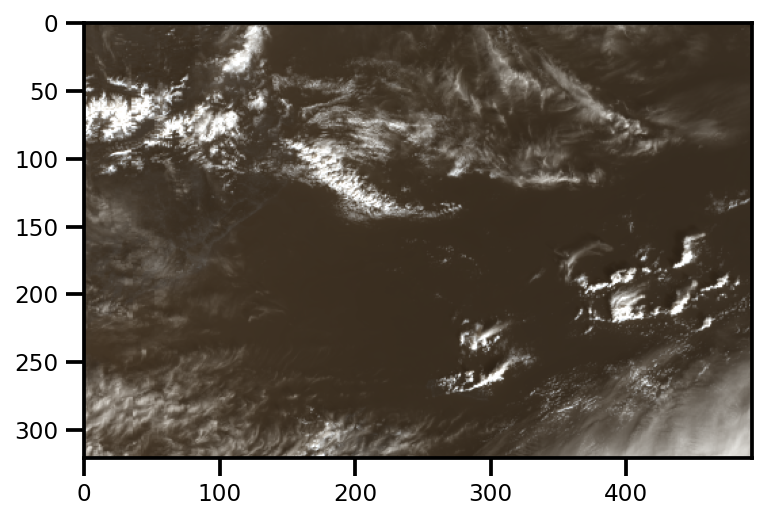

In [10]:
fig, ax = plt.subplots()

ax.imshow(data[..., composite_bands]/data[composite_bands].max())
plt.show()
wandb_logger.experiment.log({"demo_image": wandb.Image(fig)})

In [11]:
data.min(), data.max()

(0.006099999882280827, 1.502500057220459)

In [12]:
# create a long vector
X_vec = data.reshape(-1, data.shape[-1])
X_vec.shape

(158253, 15)

In [13]:
# scale data
from sklearn.preprocessing import StandardScaler

x_transformer = StandardScaler()

X_vec_s = x_transformer.fit_transform(X_vec)

In [14]:
X = np.array(X_vec_s, dtype=np.float32)
X.shape, X.dtype

((158253, 15), dtype('float32'))

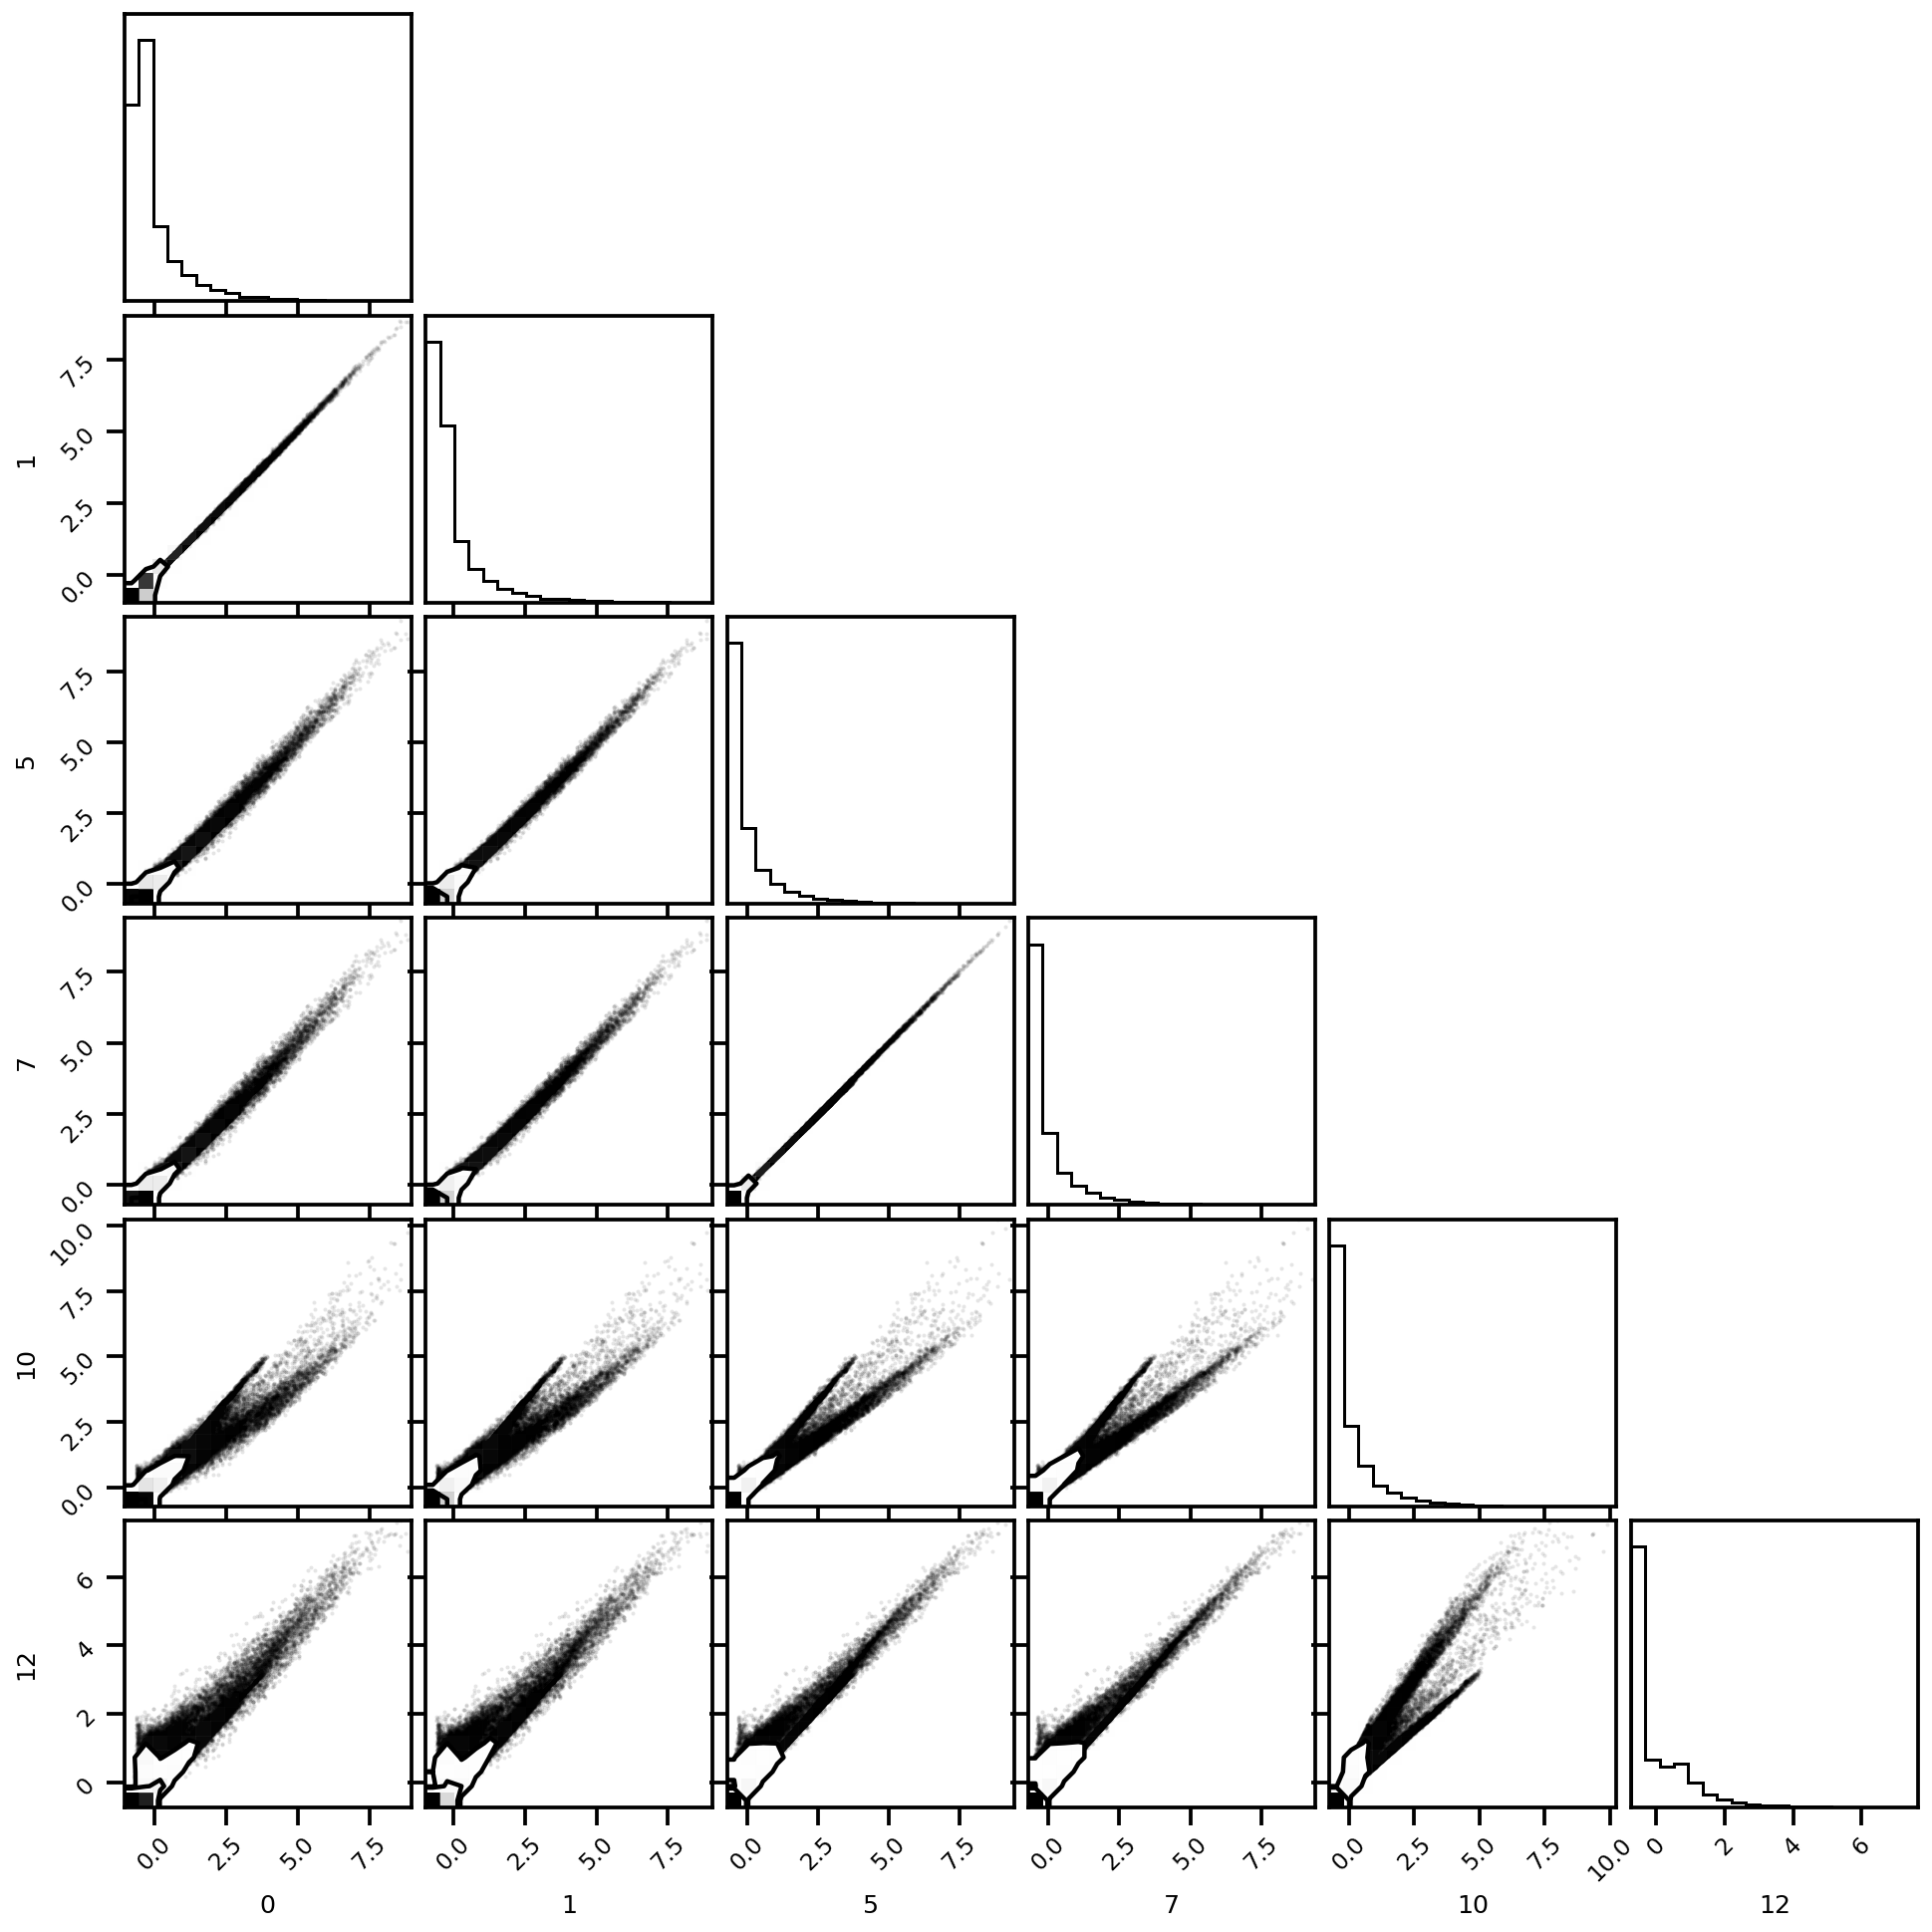

In [17]:
import corner

bands = [0, 1, 5, 7, 10, 12]

figure = corner.corner(
    data=X[..., bands],
    labels=bands,
    color="black"
)
wandb_logger.experiment.log({"corner_data": wandb.Image(fig)})

### Train-Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
data_train, data_valid = train_test_split(X, test_size=0.1, random_state=123)

In [20]:
X_train = torch.FloatTensor(data_train)
X_valid = torch.FloatTensor(data_valid)

# make into dataset
train_ds = TensorDataset(X_train)
valid_ds = TensorDataset(X_valid)

# make dataloader
batch_size = 256
num_workers = 8
shuffle = True

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Model

### Lightning Module

In [21]:
from src.lit_plane import FlowLearnerPlane

In [44]:
import ml_collections

cfg = ml_collections.ConfigDict()
cfg.num_epochs = 10
cfg.learning_rate = 1e-4
cfg.loss_fn = "inn"
cfg.n_layers = 8
cfg.n_reflections = 2
cfg.n_features = n_features

### Standard RVP

In [45]:
# # FrEIA imports
# import FrEIA.framework as Ff
# import FrEIA.modules as Fm
# from src.models.layers.coupling import get_coupling_layer

# N_DIM = X_vec.shape[1]

# # we define a subnet for use inside an affine coupling block
# # for more detailed information see the full tutorial
# def subnet_fc(dims_in, dims_out):
#     return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
#                          nn.Linear(512,  dims_out))

# # a simple chain of operations is collected by ReversibleSequential
# inn = Ff.SequenceINN(N_DIM)
# for k in range(8):
#     inn.append(
#         Fm.AllInOneBlock, 
#         subnet_constructor=subnet_fc, 
#         permute_soft=True, 
#         gin_block=False, 
#         learned_householder_permutation=0
#         )

# base_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [46]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.coupling import get_coupling_layer

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(cfg.n_features)

for k in range(cfg.n_layers):
    
    # coupling transform (GLOW)
    coupling_transform = get_coupling_layer(coupling="glow")
    
    # create coupling transform
    inn.append(
        coupling_transform, 
        subnet_constructor=subnet_fc,
    )
    
    # orthogonal transformation
    inn.append(Fm.HouseholderPerm, n_reflections=cfg.n_reflections)

base_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#### Initial Transformation

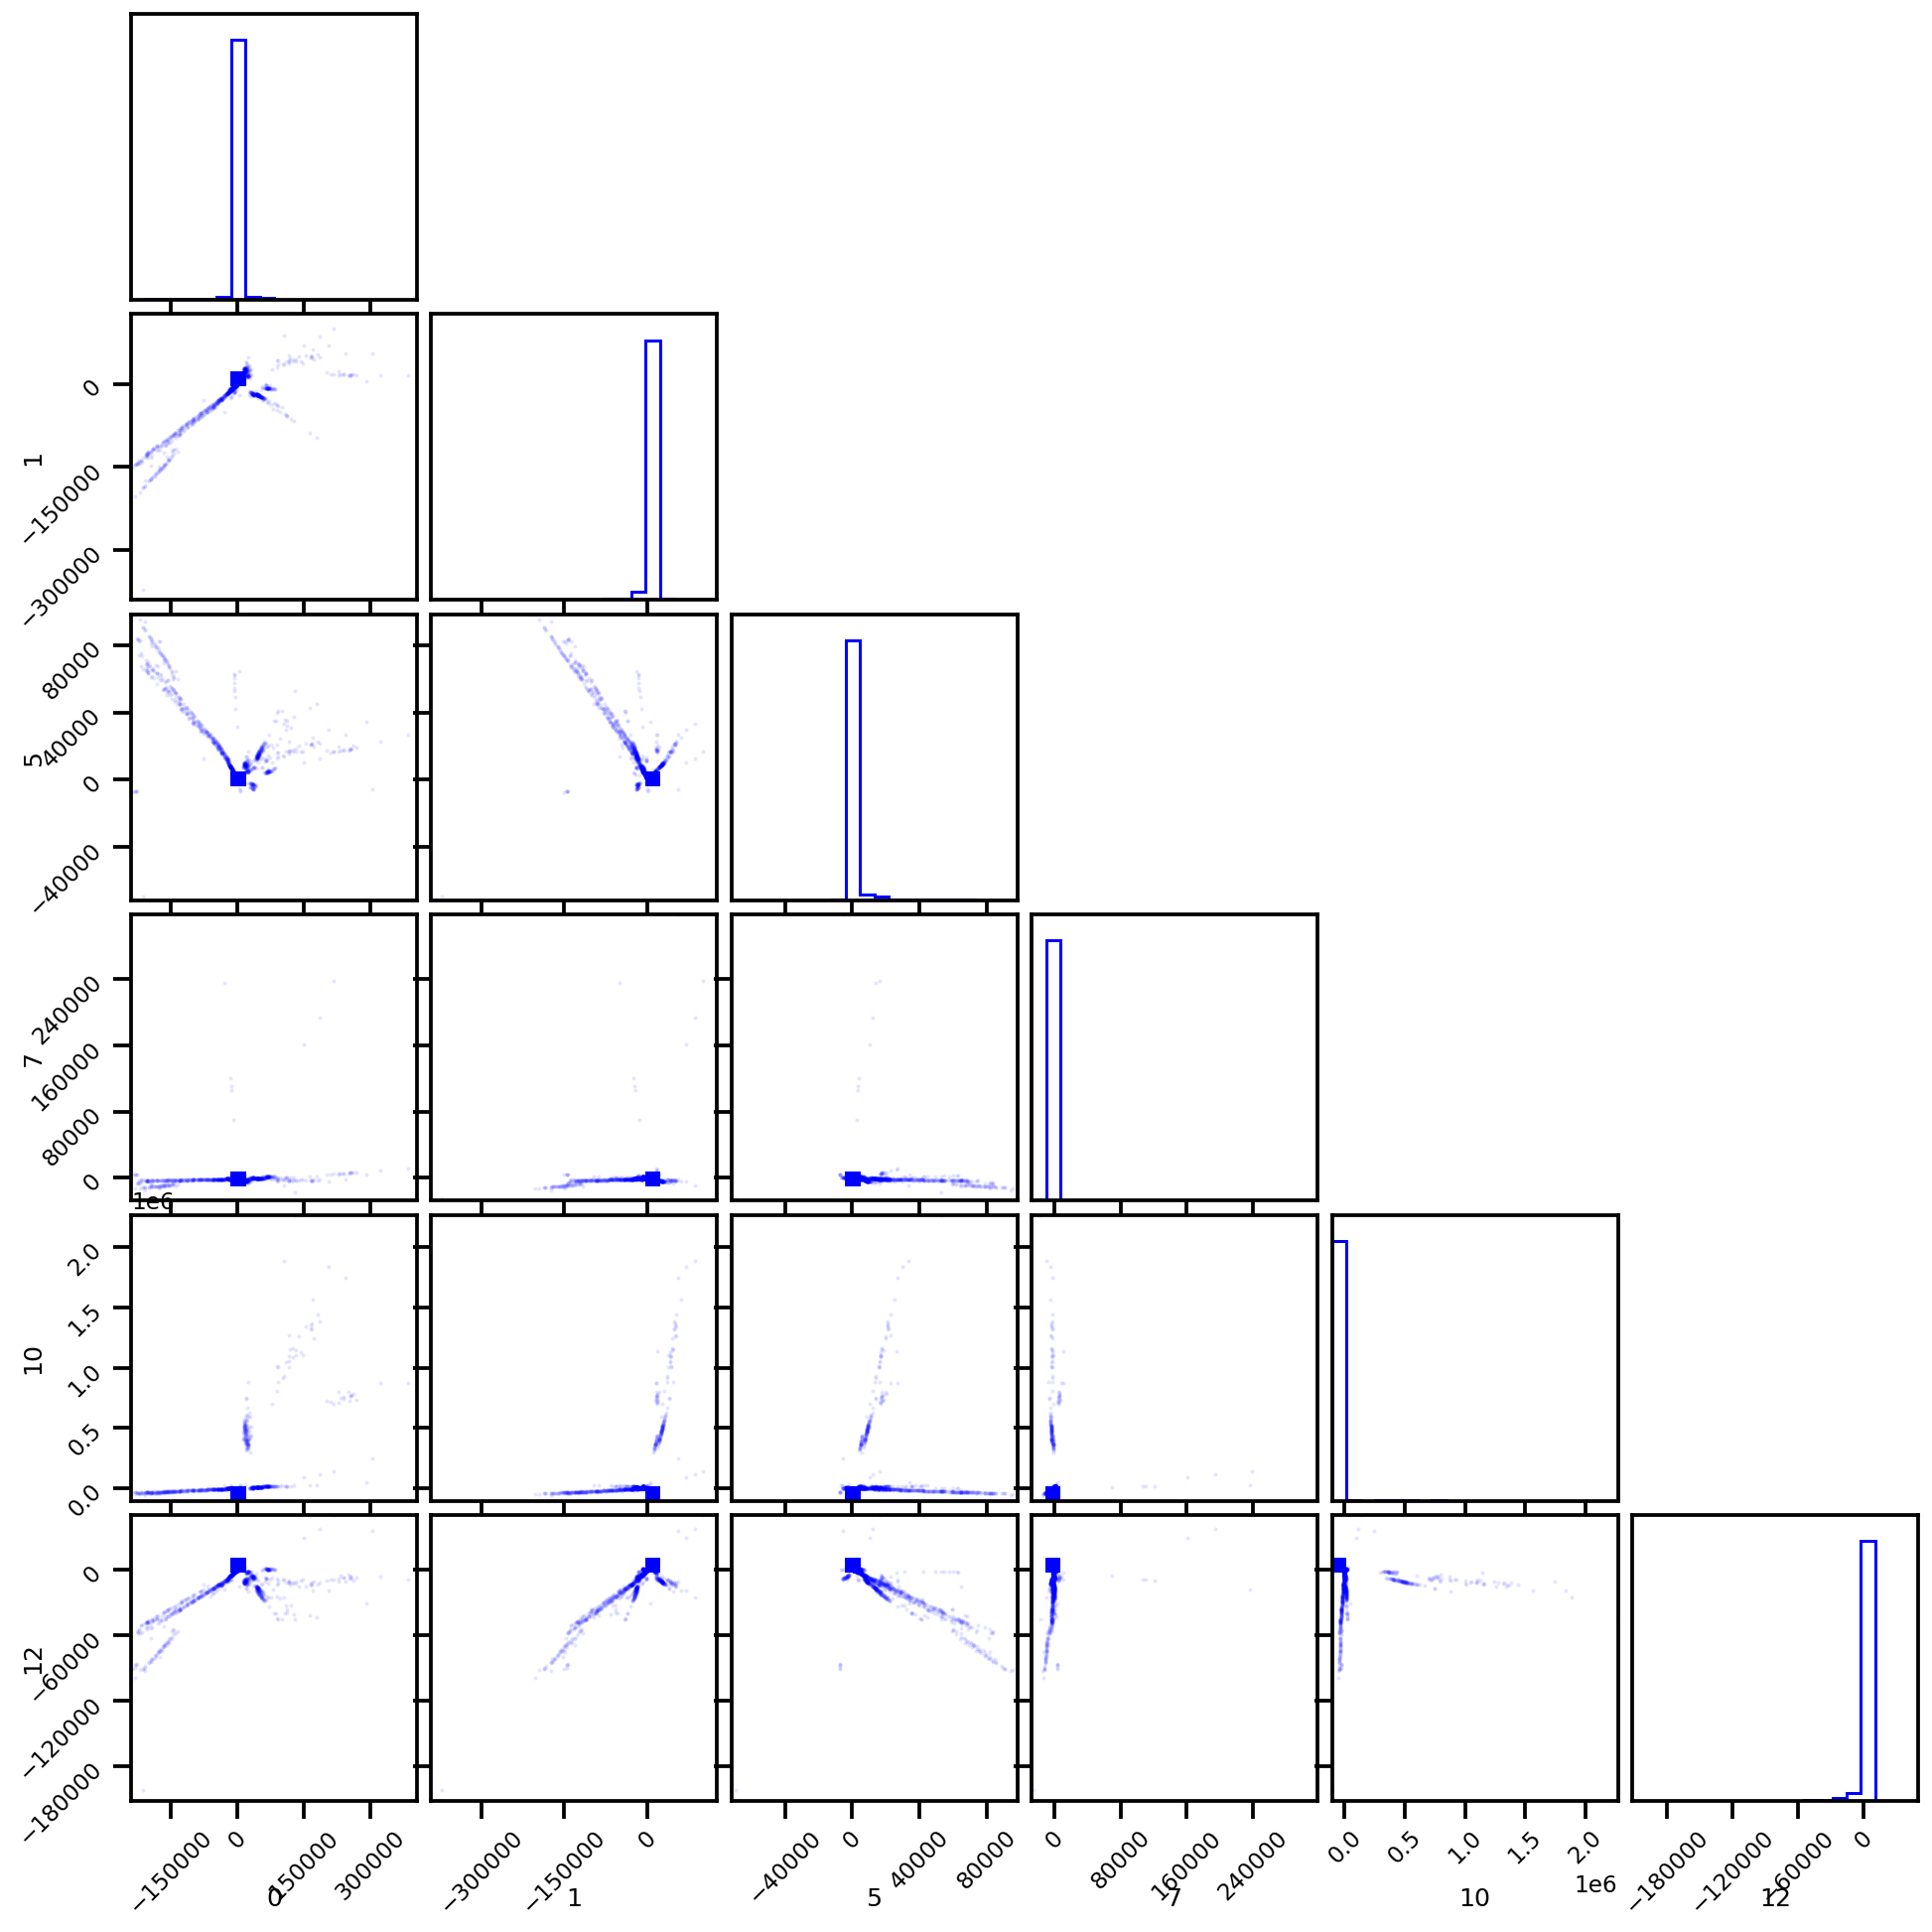

In [47]:
z, log_jac_det = inn(X_valid)

fig = corner.corner(
    z.detach().numpy()[..., bands], 
    labels=bands,
    hist_factor=2, 
    color="blue")

wandb_logger.experiment.log({"latent_initial": wandb.Image(fig)})

## Training

In [48]:
learn = FlowLearnerPlane(inn,  base_dist, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=1, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm'
, 
    logger=wandb_logger
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 192 K 
--------------------------------------
192 K     Trainable params
0         Non-trainable params
192 K     Total params
0.772     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### Latent Space

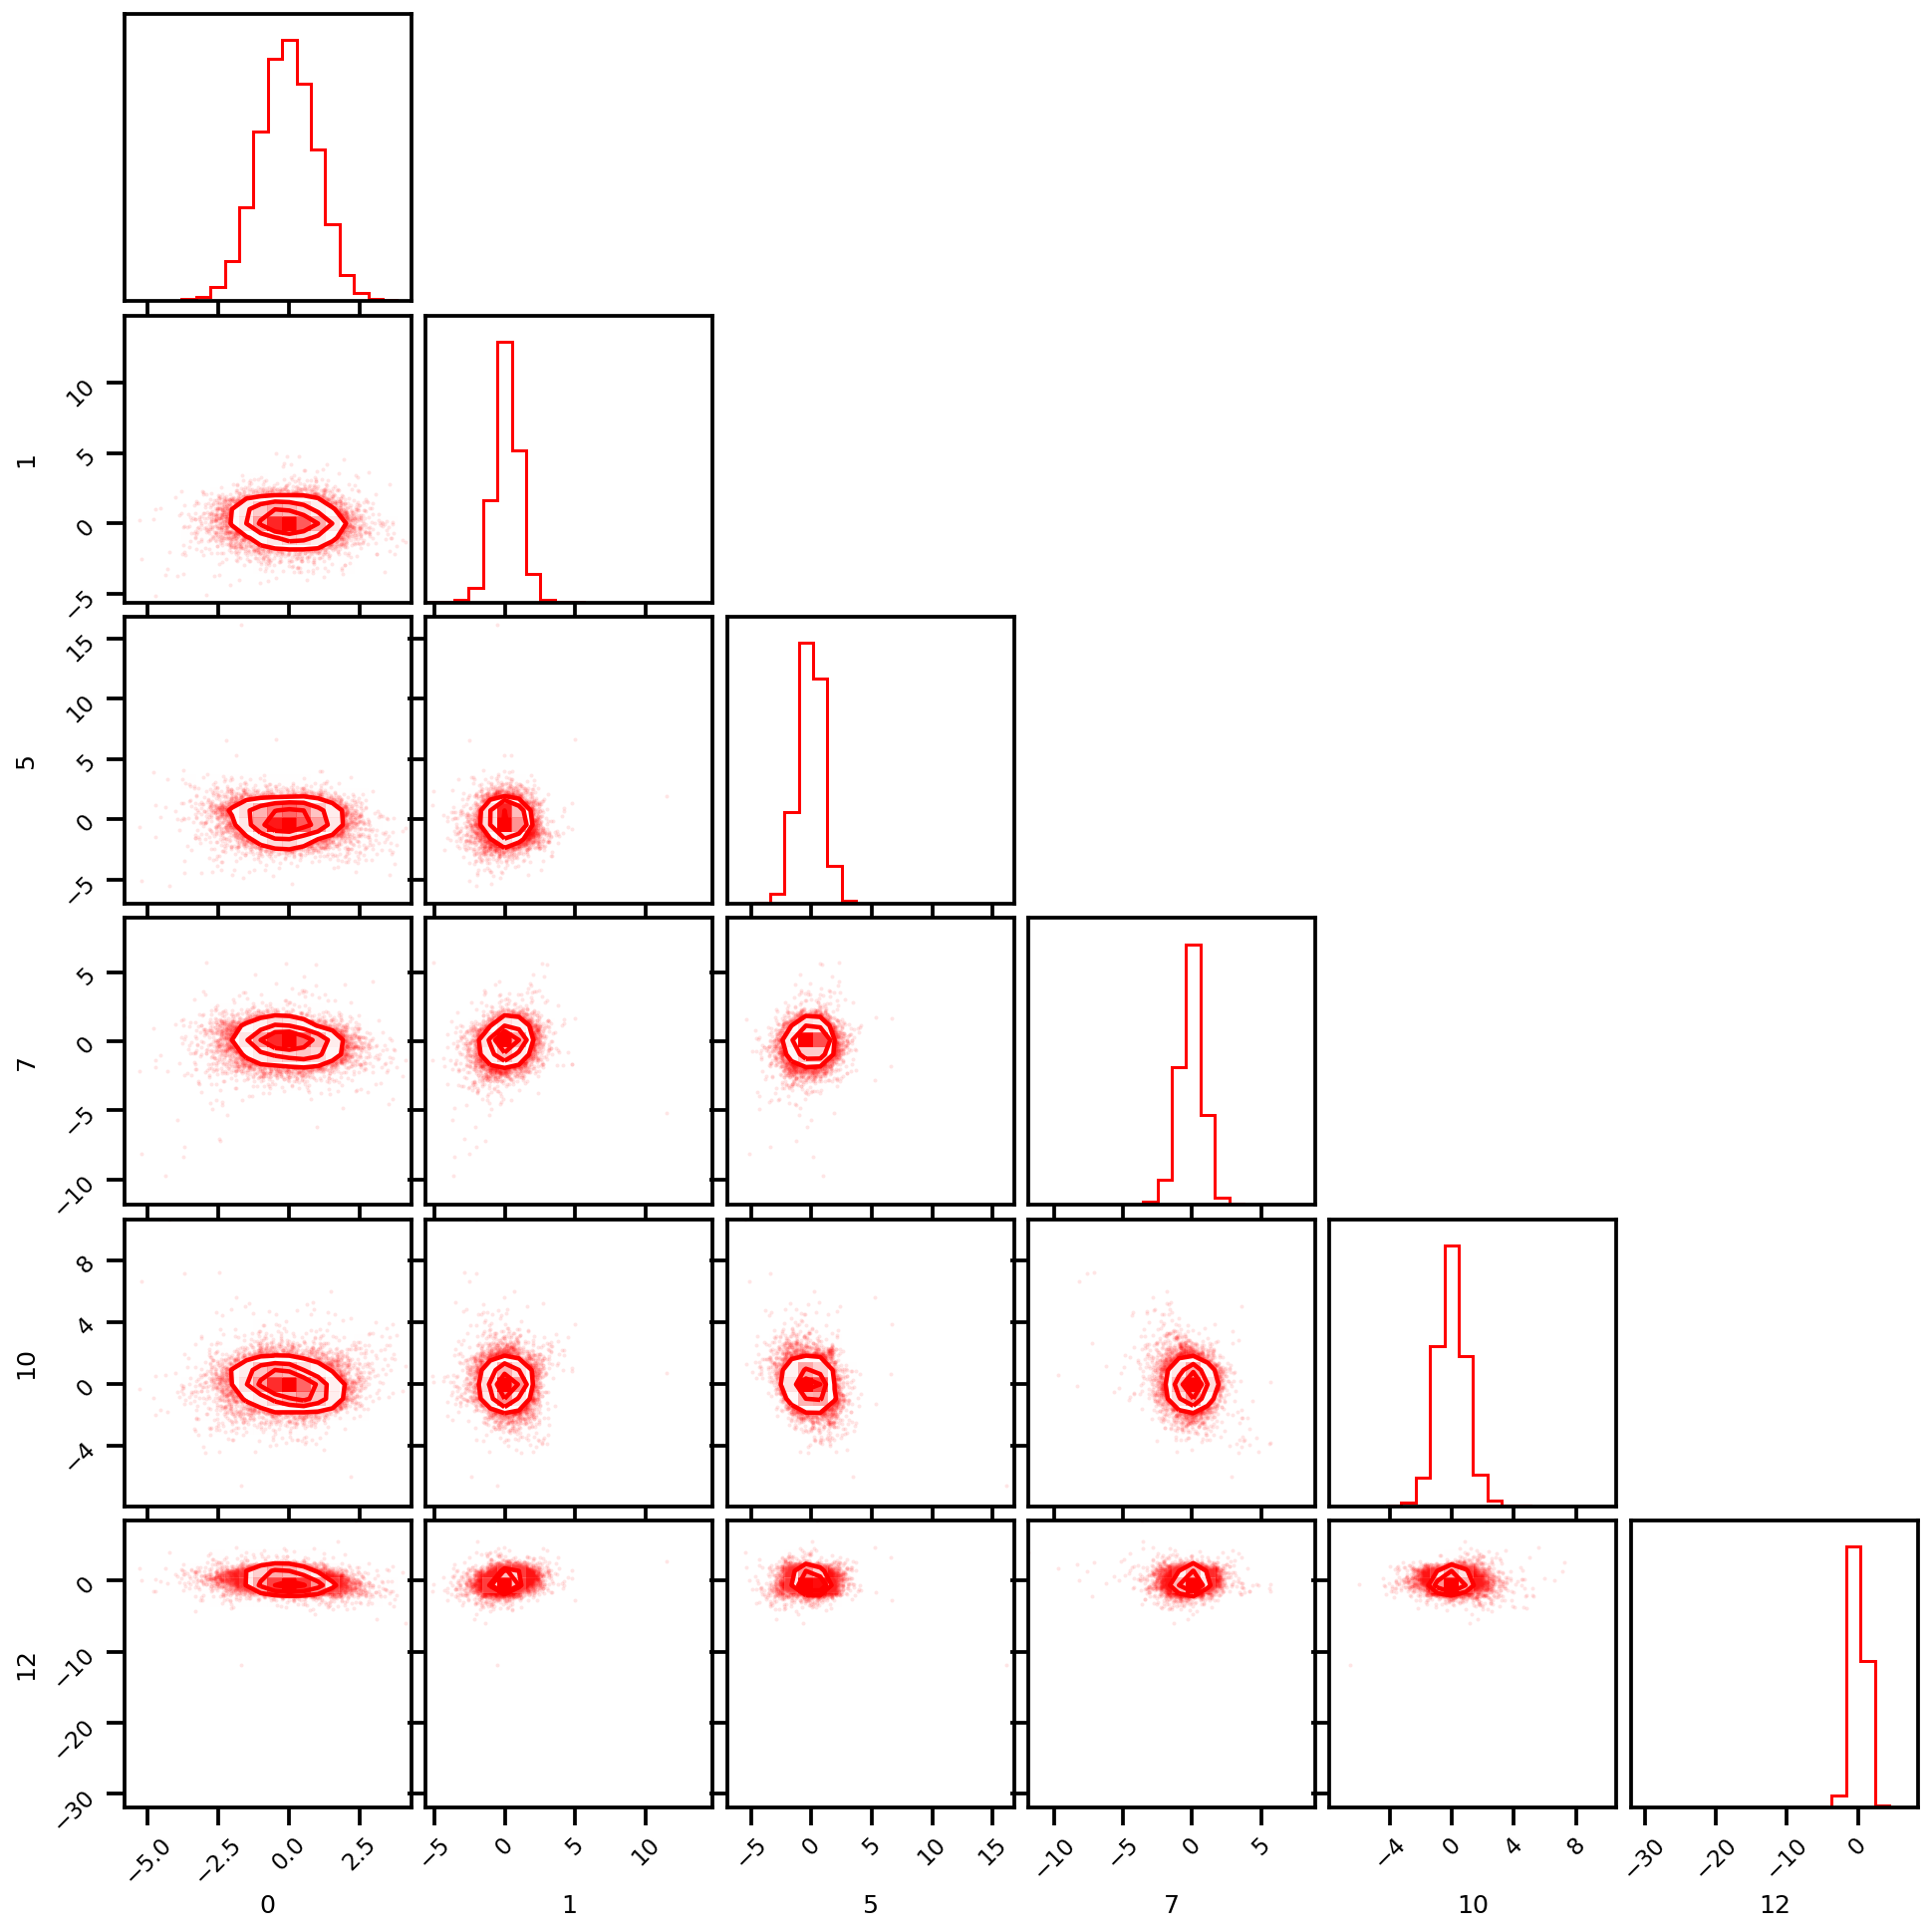

In [49]:
z, log_jac_det = learn.model(X_valid)

fig = corner.corner(
    z.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="red")
wandb_logger.experiment.log({"latent_trained": wandb.Image(fig)})

#### Inverse Transform

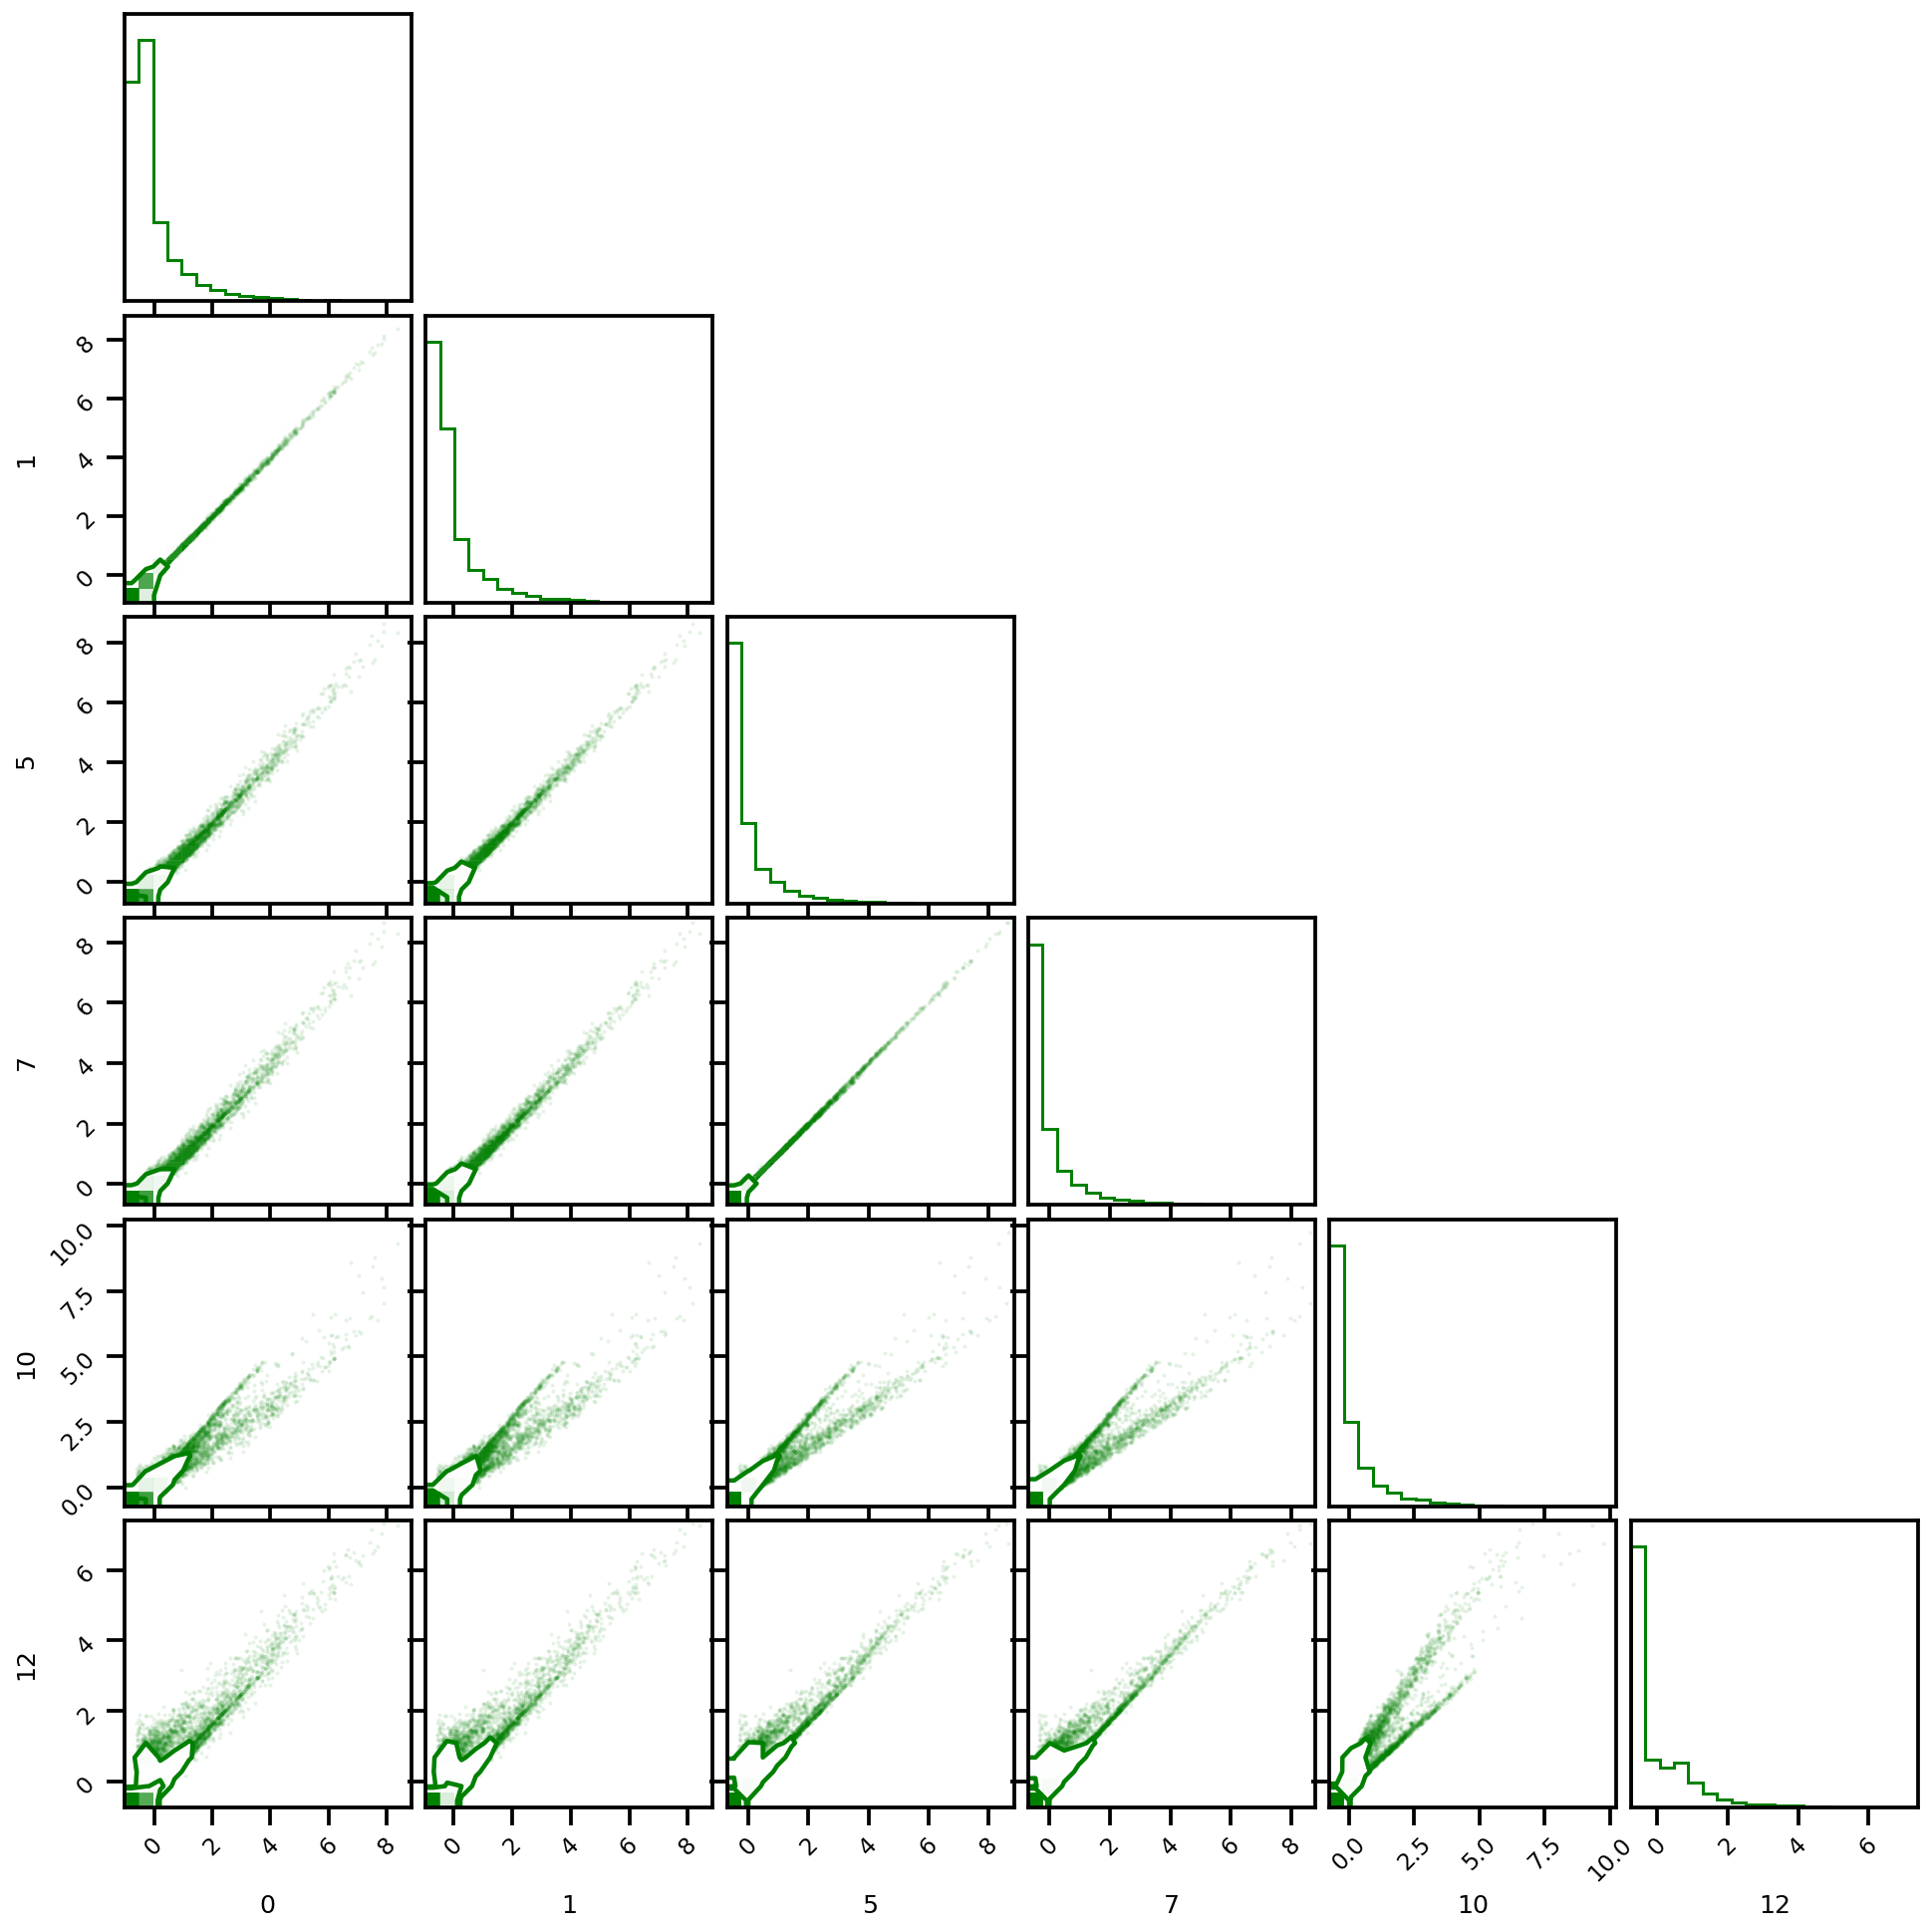

In [50]:
x_ori, _ = learn.model(z, rev=True)


fig = corner.corner(
    x_ori.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="green")
wandb_logger.experiment.log({"latent_trained_inv": wandb.Image(fig)})

#### Sampling

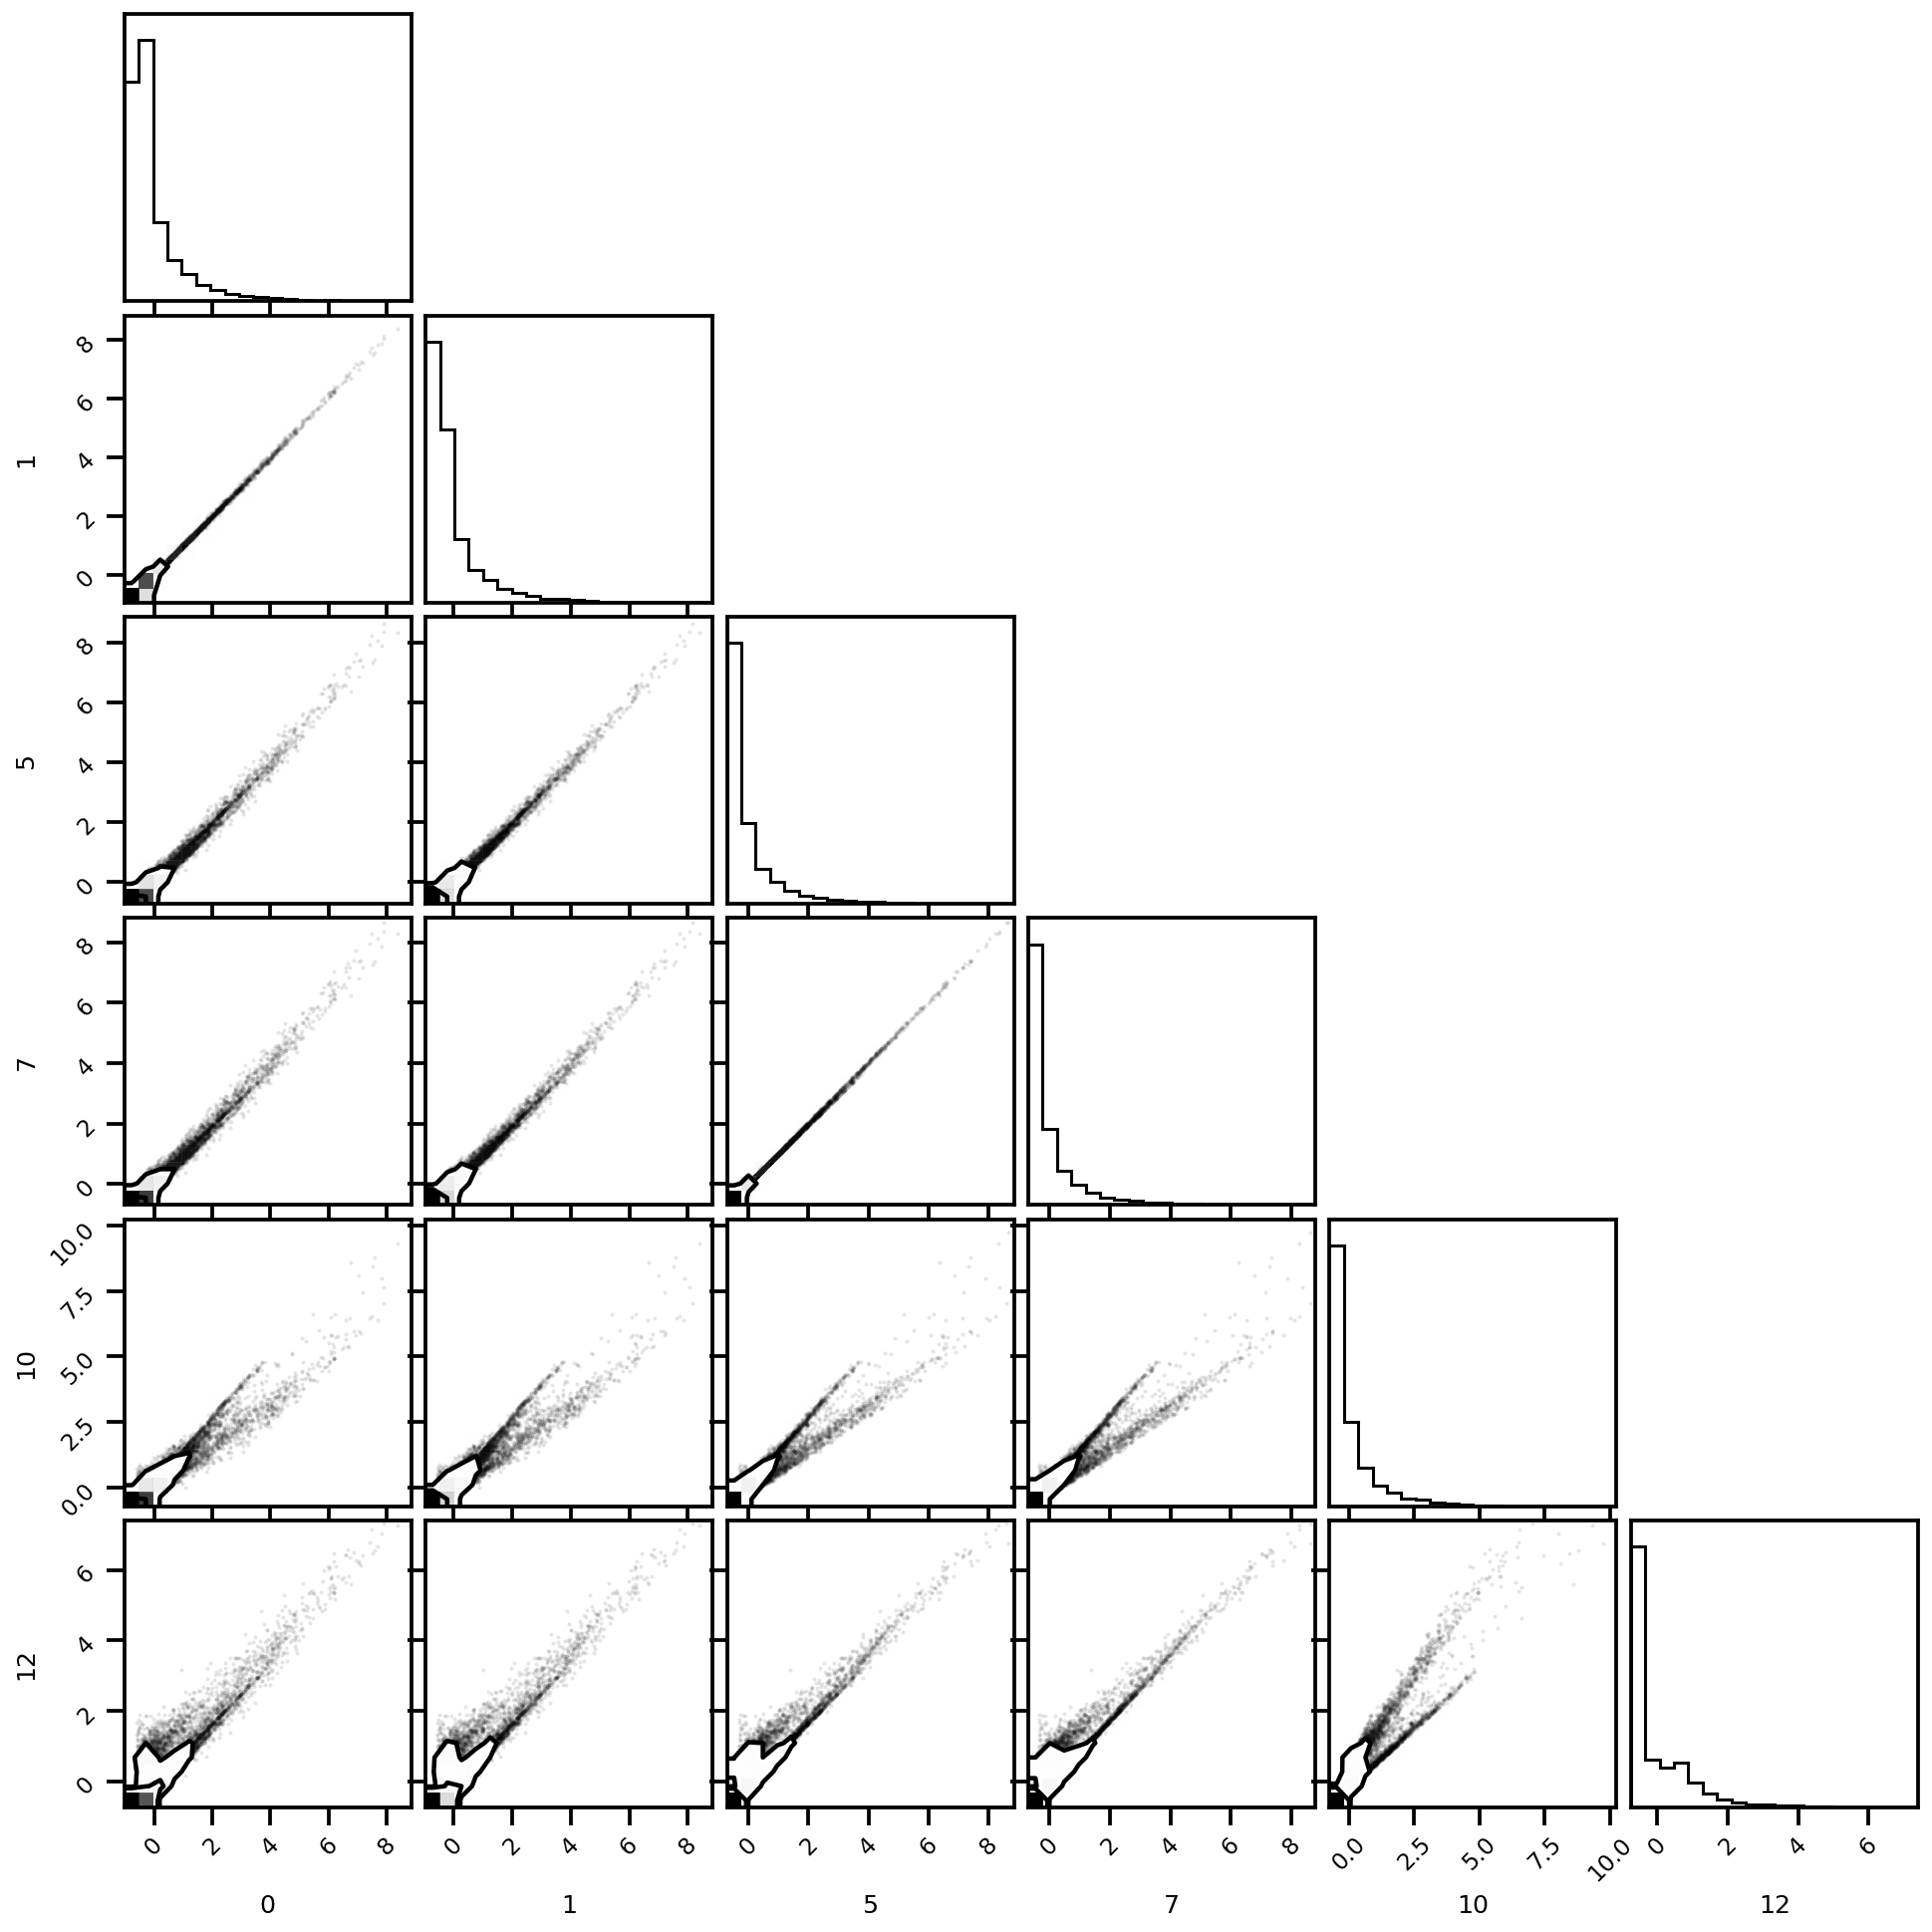

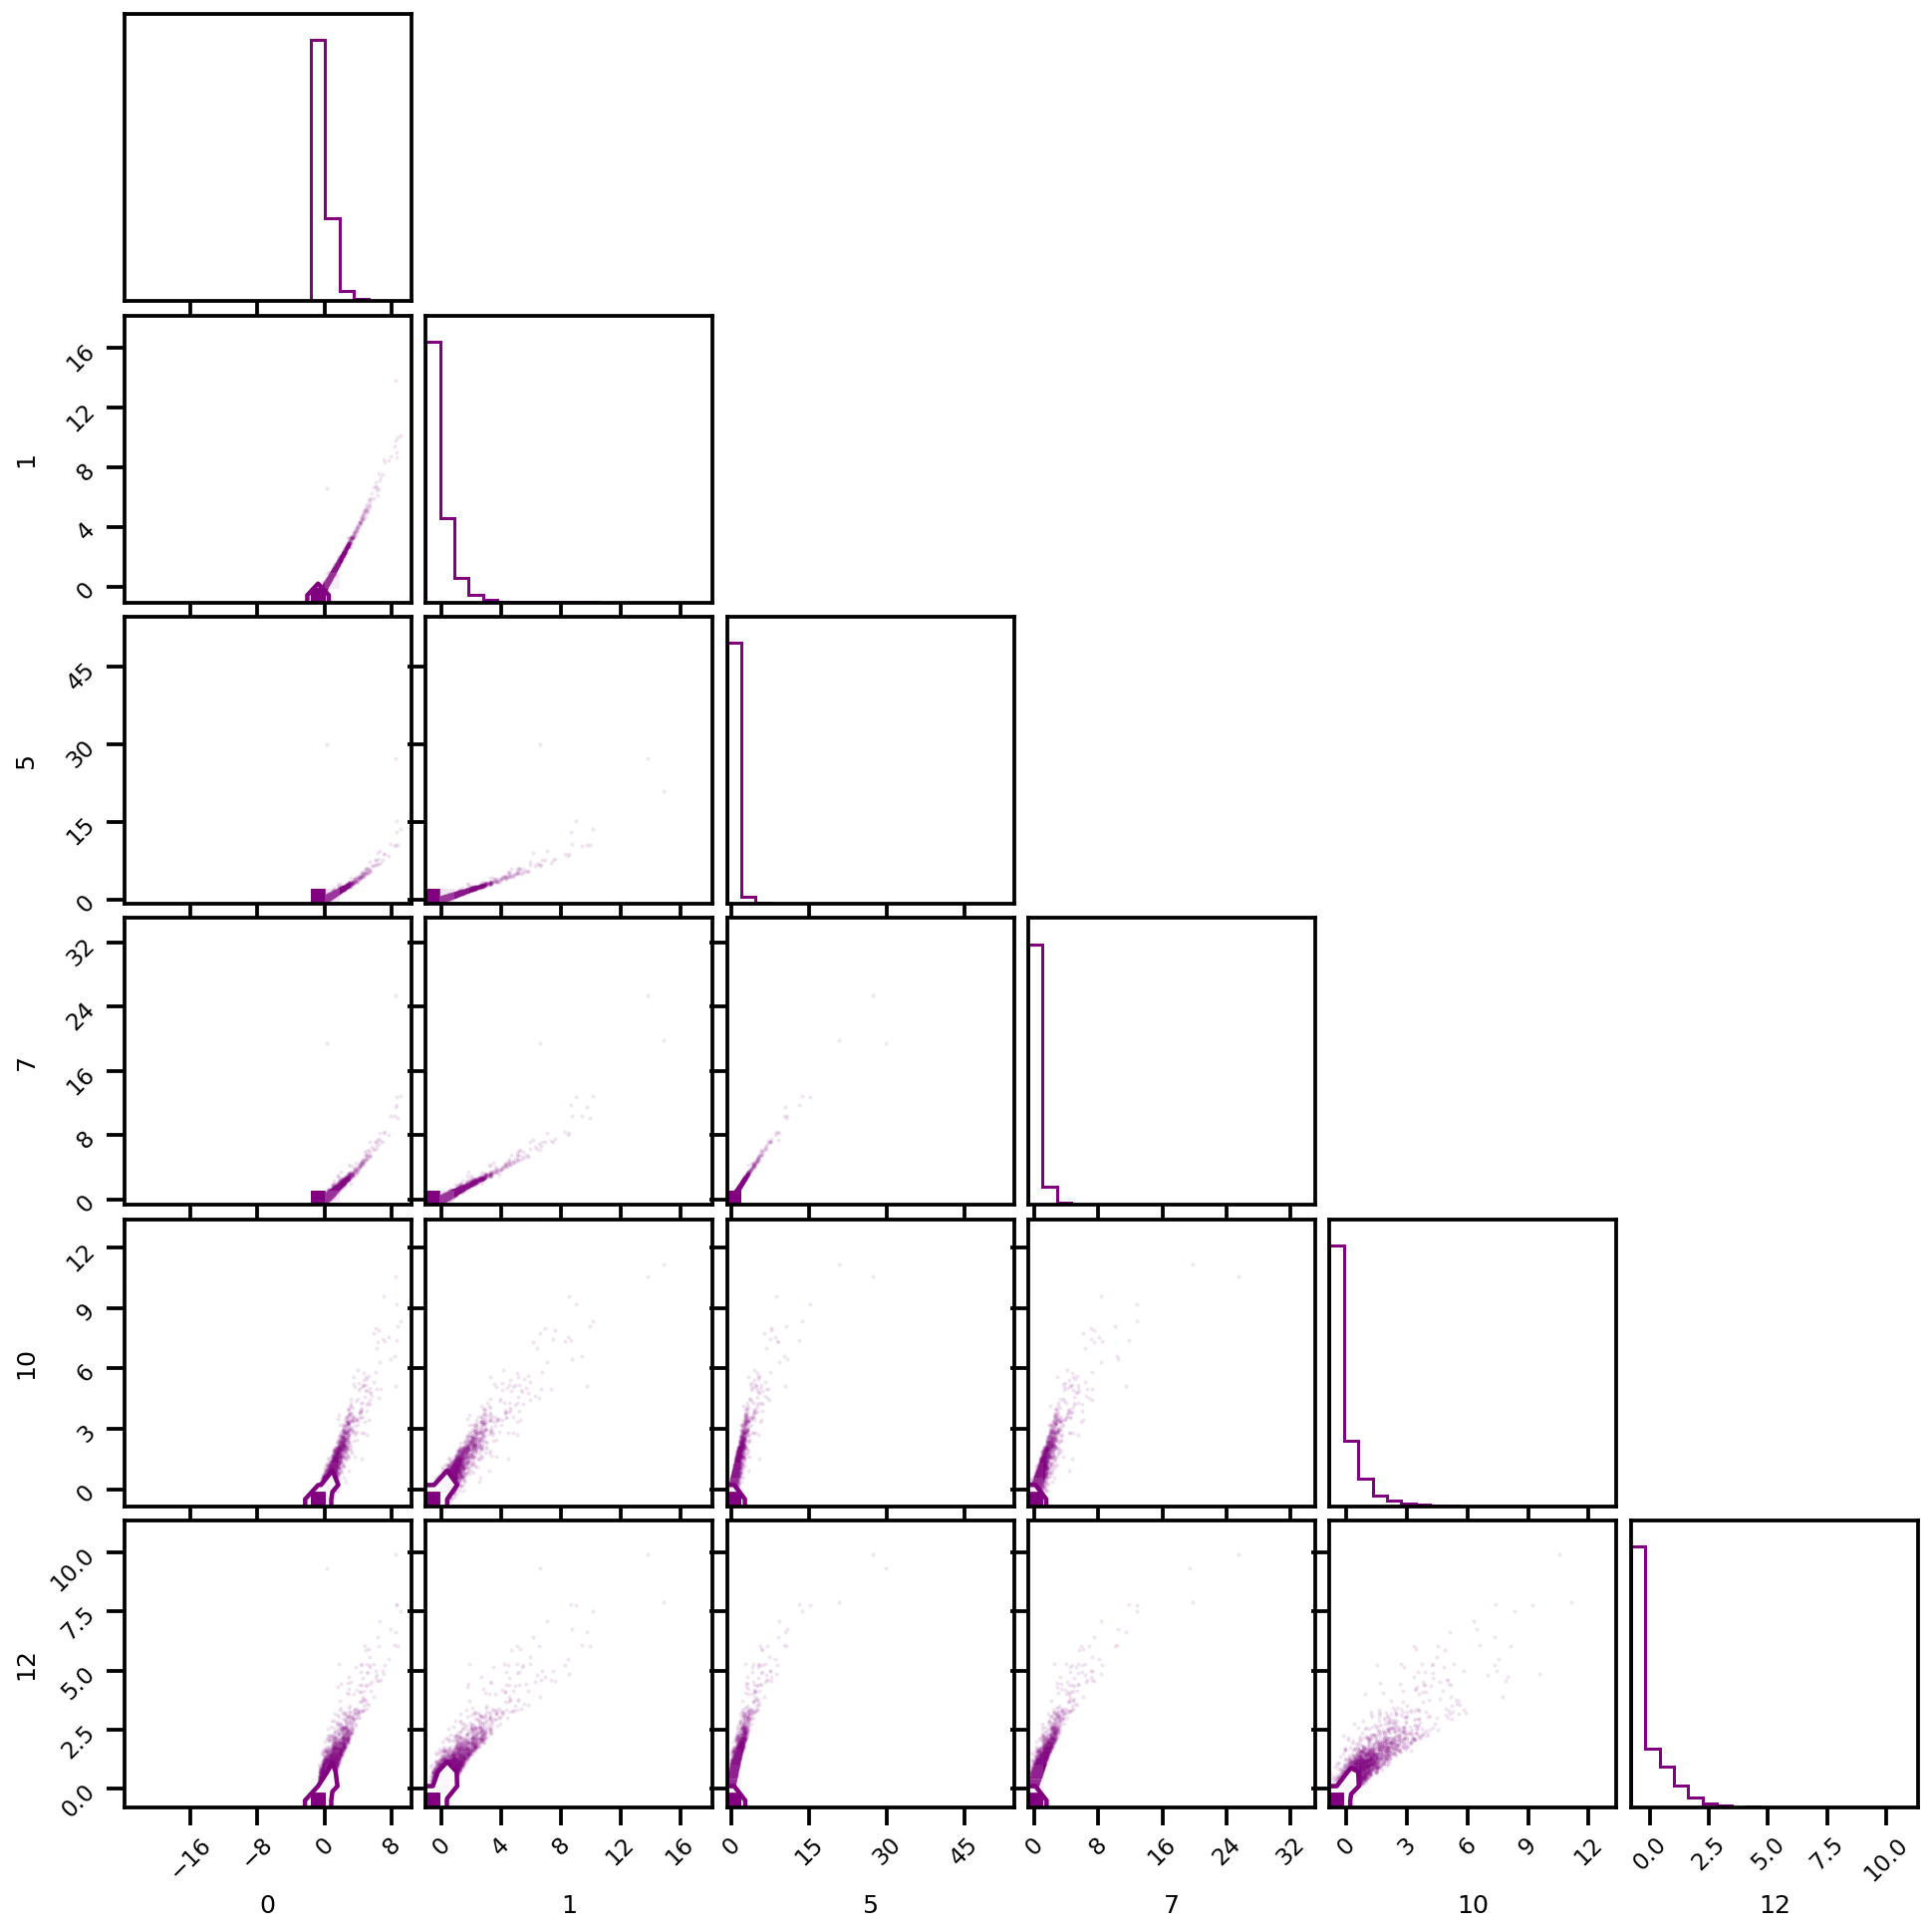

In [51]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, n_features)
samples, _ = learn.model(z, rev=True)


fig = corner.corner(
    X_valid.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="black")
fig = corner.corner(
    samples.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="purple")
wandb_logger.experiment.log({"sampling_trained": wandb.Image(fig)})

## Custom Layer

2021-07-02 11:53:06,024:WARNING:Too few points to create valid contours
2021-07-02 11:53:06,077:WARNING:Too few points to create valid contours
2021-07-02 11:53:06,112:WARNING:Too few points to create valid contours
2021-07-02 11:53:06,154:WARNING:Too few points to create valid contours
2021-07-02 11:53:06,179:WARNING:Too few points to create valid contours
2021-07-02 11:53:06,203:WARNING:Too few points to create valid contours


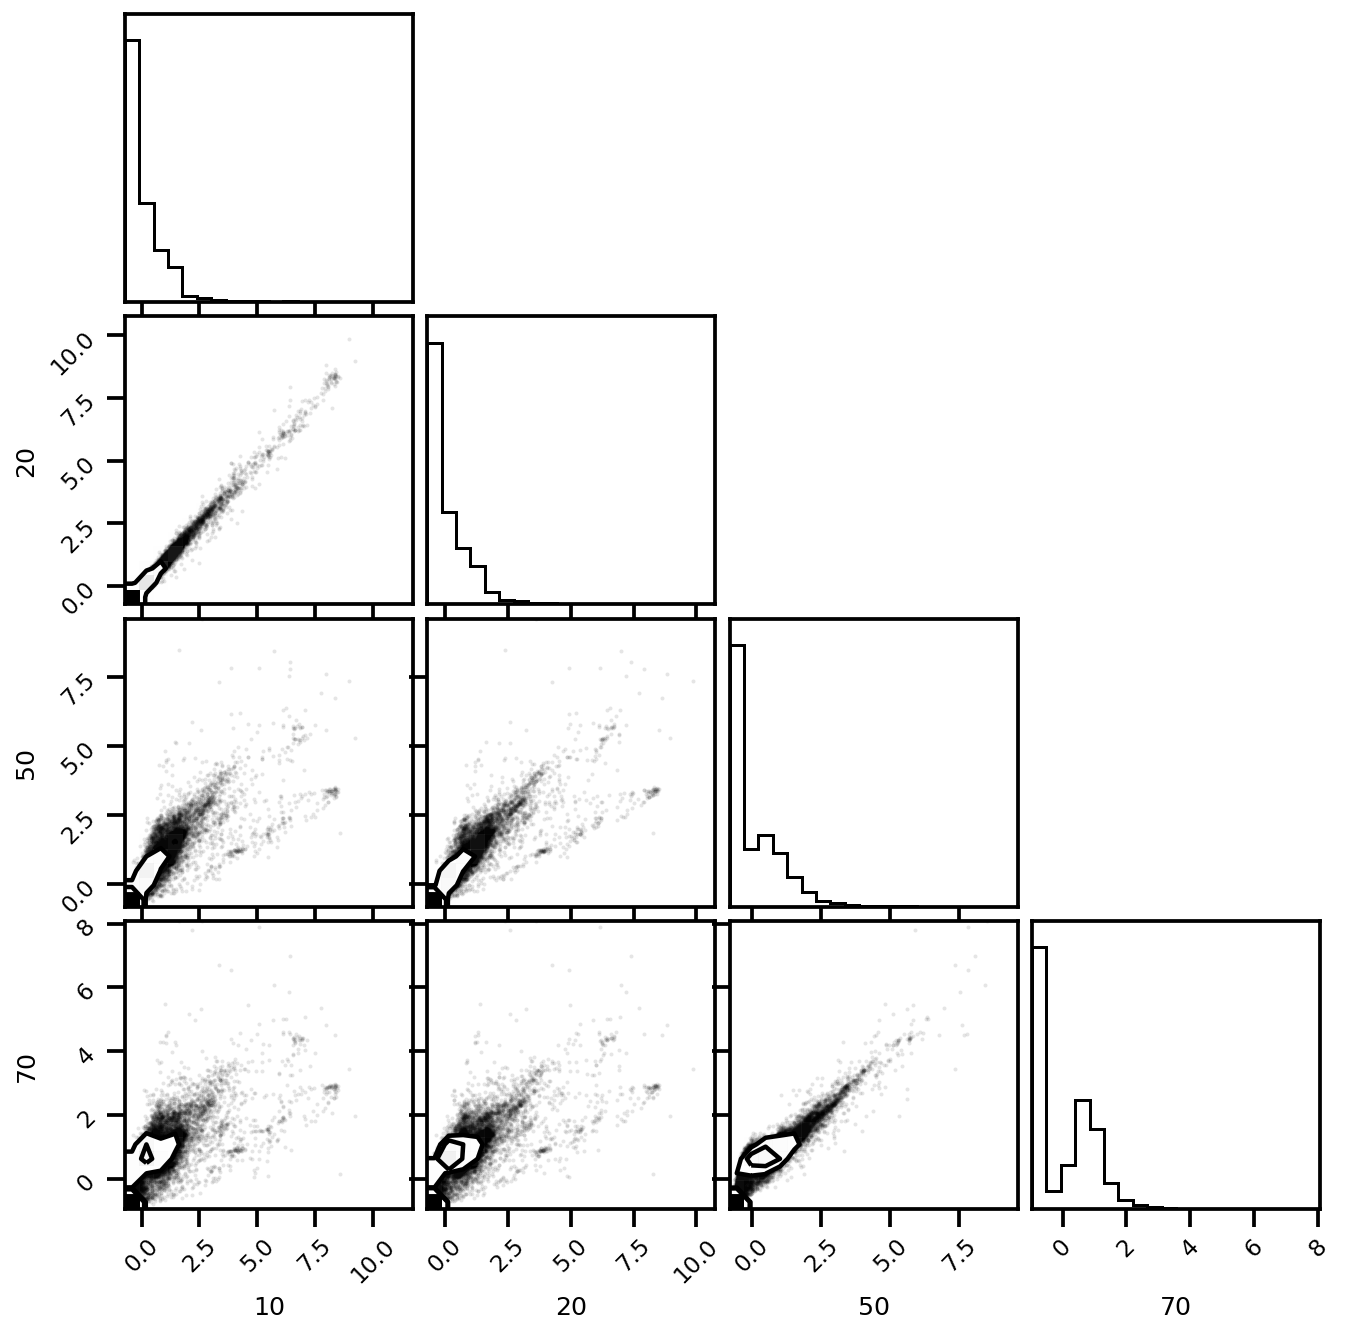

In [169]:
fig = corner.corner(
    X_valid.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="black")

In [247]:
import ml_collections

cfg = ml_collections.ConfigDict()
cfg.loss_fn = "inn"
cfg.num_epochs = 5
cfg.learning_rate = 1e-3
cfg.batch_size = 100
cfg.weight_decay = 0.0
cfg.beta1 = 0.9
cfg.beta2 = 0.999
cfg.betas = (cfg.beta1, cfg.beta2)

#### Mixture CDF Flows

In [248]:
def tensor2numpy(x):
    return x.detach().cpu().numpy()
def numpy2tensor(x):
    return torch.Tensor(x)

In [249]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from tqdm.notebook import trange

from src.models.layers.rqs import RQSplines
from src.models.layers.mixture import GaussianMixtureCDF
from src.models.layers.mixture_log import LogisticMixtureCDF
from src.models.layers.nonlinear import InverseGaussCDF, Logit

n_features = X_vec.shape[1]
inn = Ff.SequenceINN(n_features)

init_X = [[numpy2tensor(X_train)[:5_000]], None]

for k in trange(8):

    inn.append(
        GaussianMixtureCDF, 
        n_components=5, 
        init_X=tensor2numpy(init_X[0][0])
    )
    # forward transformation
    with torch.no_grad():
        init_X = inn.module_list[-1](x=init_X[0])
    inn.append(
        InverseGaussCDF
    )
    with torch.no_grad():
        init_X = inn.module_list[-1](x=init_X[0])

    inn.append(Fm.HouseholderPerm, n_reflections=2)
    with torch.no_grad():
        init_X = inn.module_list[-1](x=init_X[0])


base_dist = dist.Normal(torch.zeros(n_features), torch.ones(n_features))

  0%|          | 0/8 [00:00<?, ?it/s]

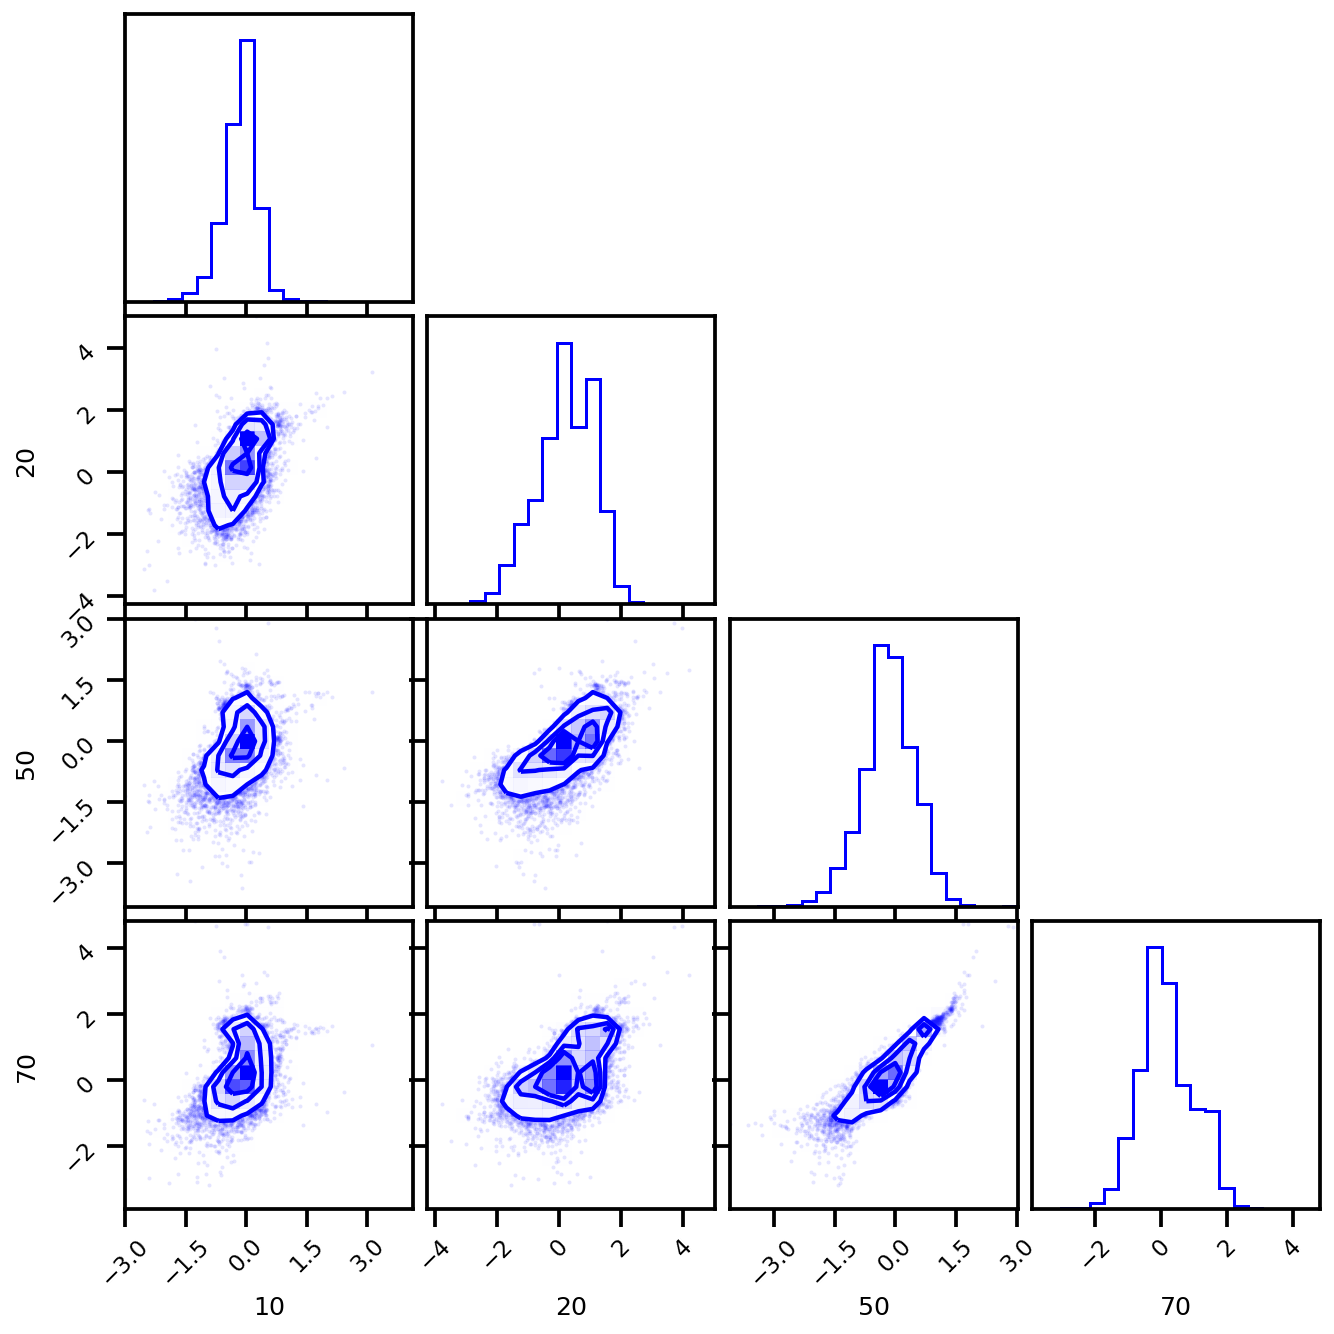

In [250]:
z, log_jac_det = inn(X_valid[:10_000])

fig = corner.corner(
    z.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="blue")

In [251]:
%%time

with torch.no_grad():
    x_ori, log_jac_det = inn(z, rev=True)

x_ori.min(), x_ori.max(), x_ori.shape, log_jac_det.shape,log_jac_det.min(), log_jac_det.max(), 

CPU times: user 1min 53s, sys: 95.5 ms, total: 1min 53s
Wall time: 4.07 s


(tensor(-3.0349),
 tensor(11.0141),
 torch.Size([10000, 102]),
 torch.Size([10000, 102]),
 tensor(-53.3356),
 tensor(3.3386))

2021-07-02 13:00:19,288:WARNING:Too few points to create valid contours


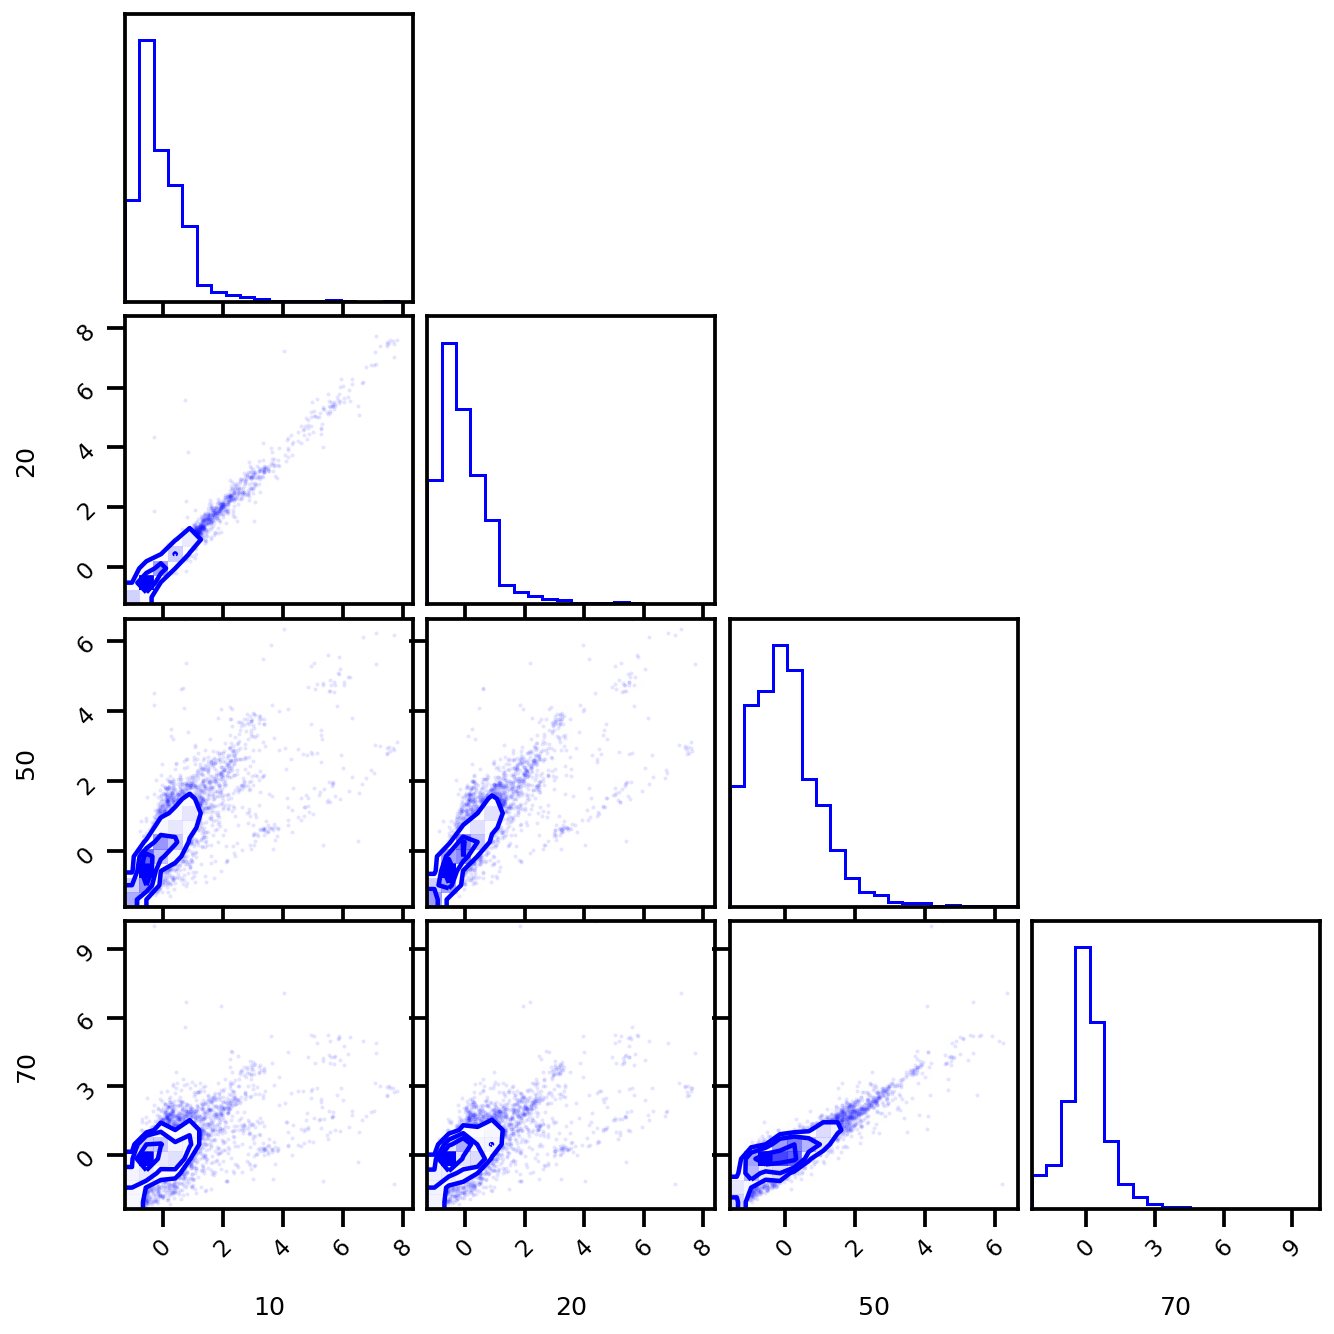

In [252]:
fig = corner.corner(
    x_ori.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="blue")

In [253]:
learn = FlowLearnerPlane(inn, base_dist, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm'
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 13.9 K
--------------------------------------
13.9 K    Trainable params
0         Non-trainable params
13.9 K    Total params
0.055     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

#### Latent Domain

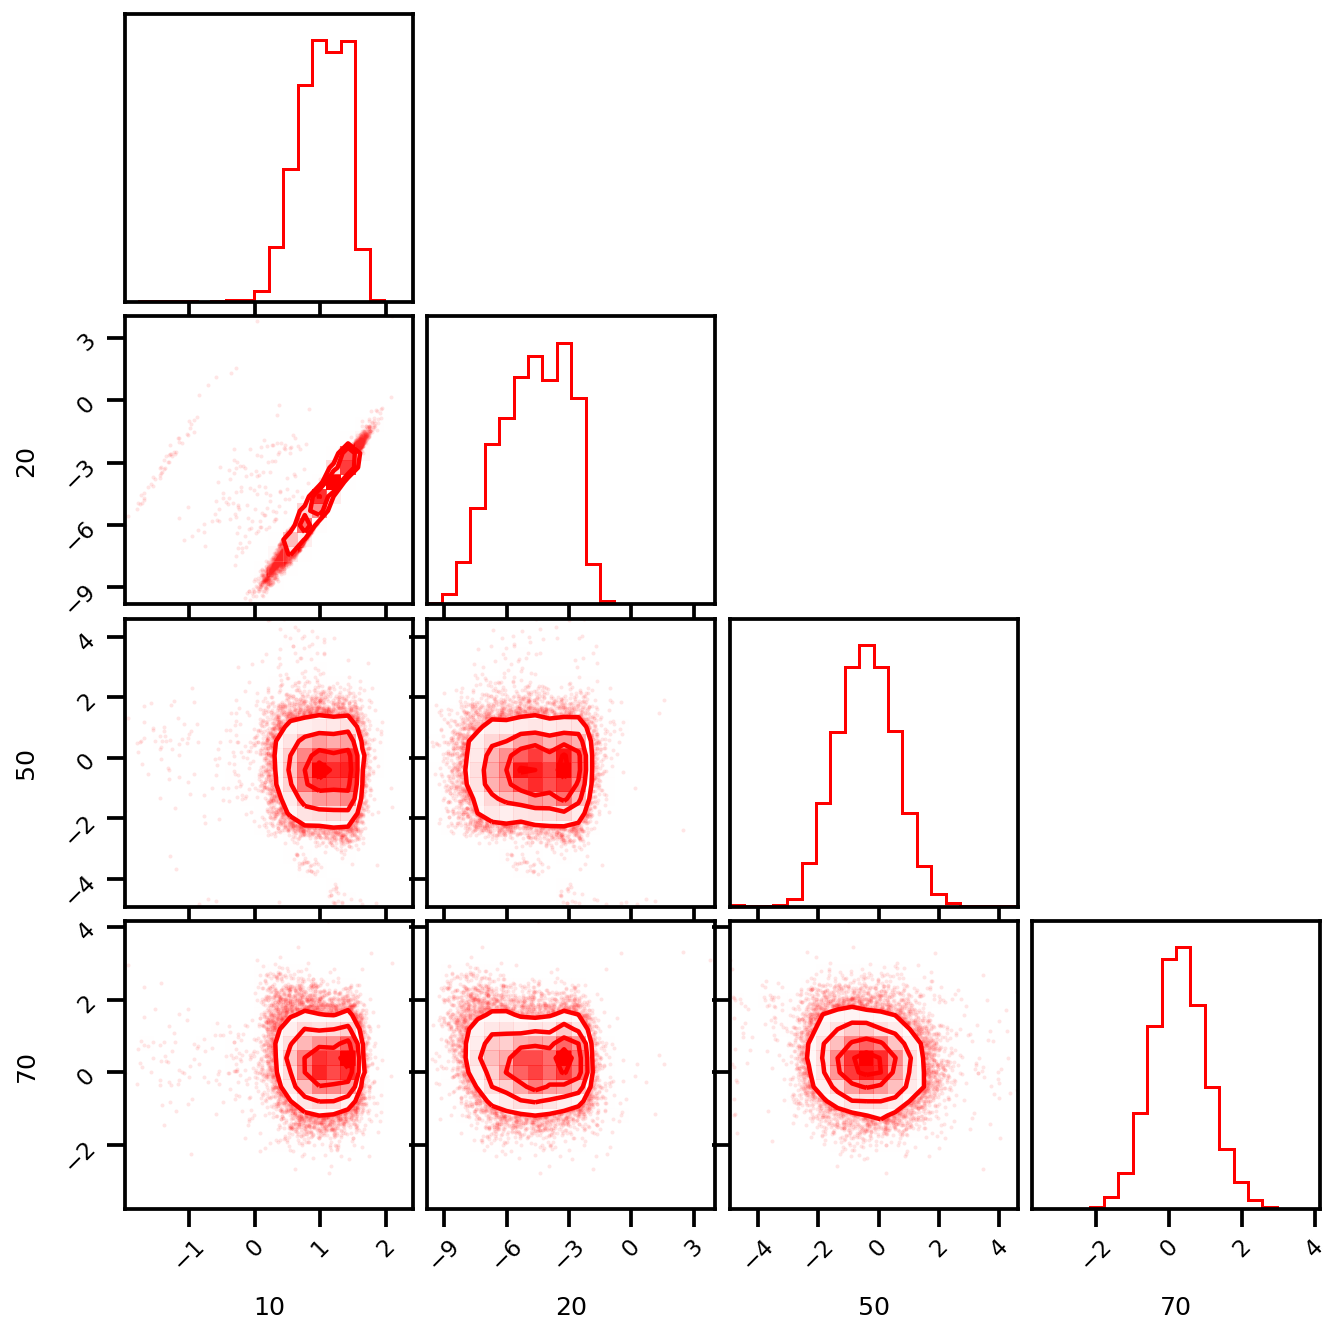

In [254]:
z, log_jac_det = learn.model(X_valid)

fig = corner.corner(
    z.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="red")

#### Inverse Transform

CPU times: user 5min 10s, sys: 1min 52s, total: 7min 2s
Wall time: 19 s


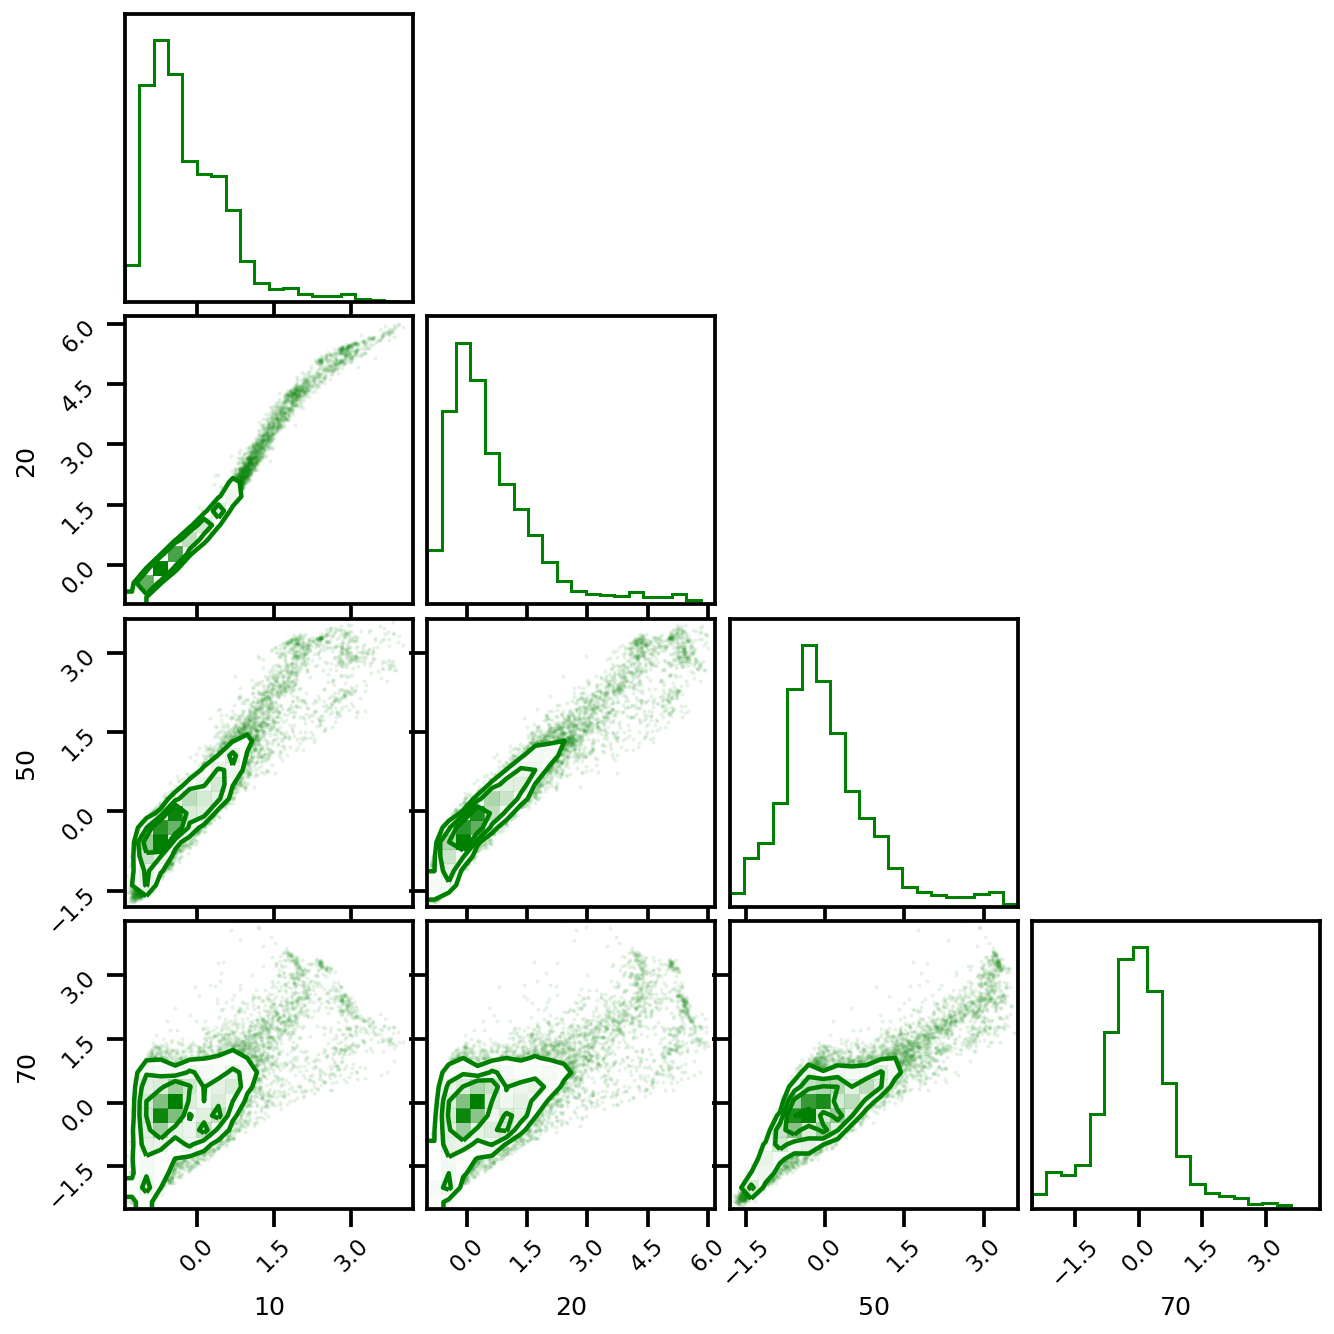

In [255]:
%%time

x_ori, _ = learn.model(z, rev=True)

fig = corner.corner(
    x_ori.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="green")

#### Sampling

In [256]:
%%time
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, n_features)
samples, _ = learn.model(z, rev=True)


CPU times: user 2min 10s, sys: 35.1 s, total: 2min 45s
Wall time: 7.09 s


2021-07-02 13:12:02,140:WARNING:Too few points to create valid contours


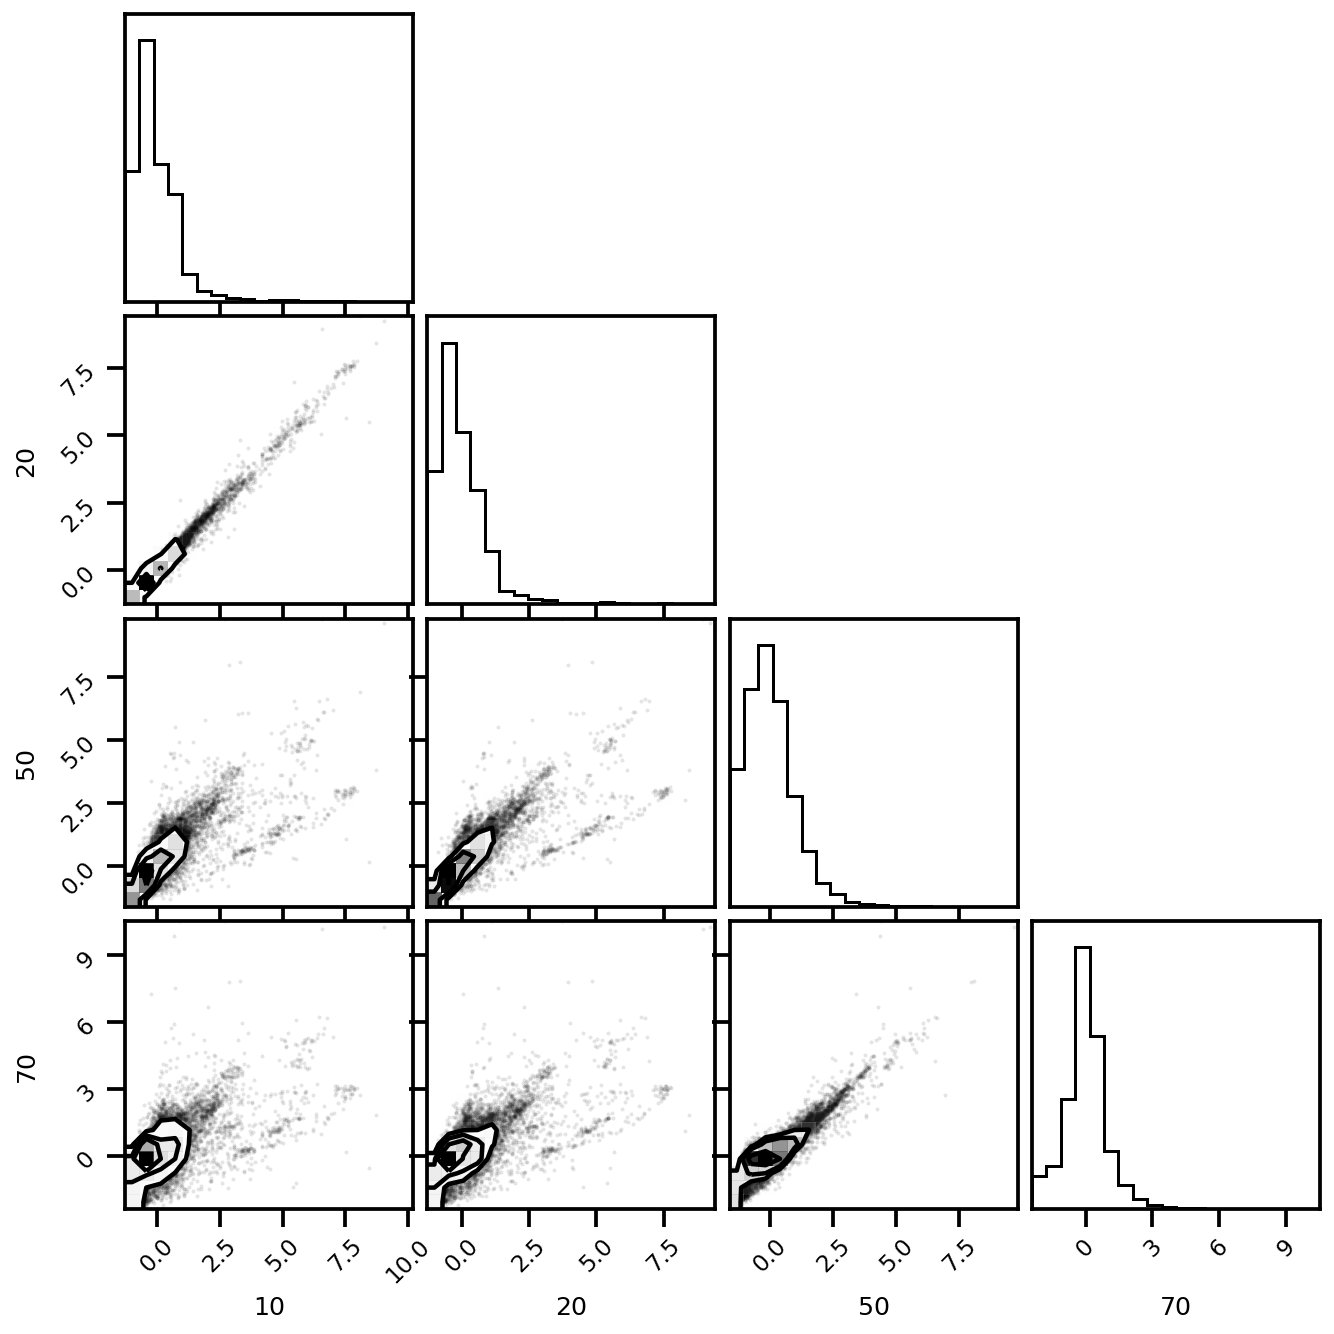

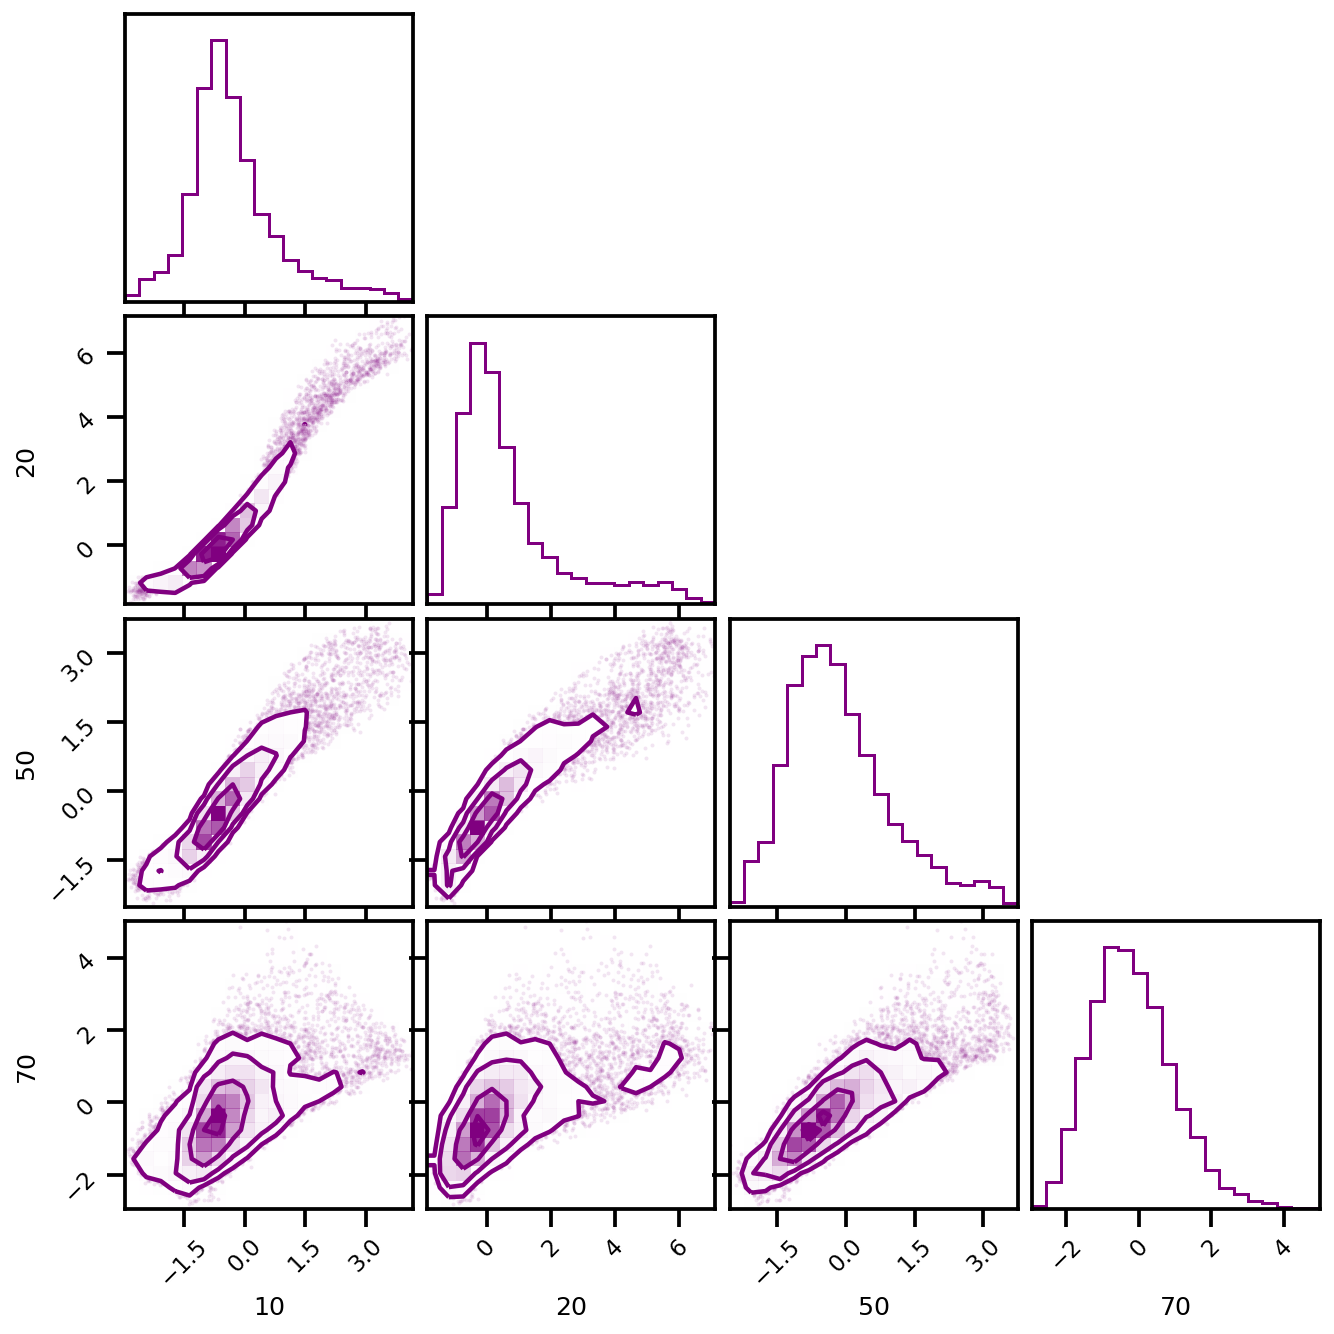

In [257]:

fig = corner.corner(
    X_valid.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="black")
fig = corner.corner(
    samples.detach().numpy()[:, bands], 
    labels=bands,
    hist_factor=2, 
    color="purple")